In [1]:
import pandas as pd

df = pd.read_csv('/content/Gold Price.csv')

df=df.dropna()

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#df['icon']= le.fit_transform(df['icon'])

y = df['High'].values
df=df.drop(columns = ['Date', 'High'])
X = df.values

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 2. , 1. , 0. , 1. , 4. , 2. , 5. , 3. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 4.5])

In [2]:

y=y.reshape(-1, 1)


import numpy as np
X=np.concatenate((X[1:], y[0:-1]), axis=1)

In [2]:
pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=3a6869f7eda4c475212288856f7b83001d8d95ff8694f24ebe8c2fb9c9b3d7dd
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-self-attention


In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X= sc.fit_transform(X)

In [ ]:
pip install pyrcn

     |████████████████████████████████| 81 kB 3.5 MB/s 


In [3]:
from sklearn.model_selection import train_test_split
x_train1, x_test1, y_train1, y_test1 = train_test_split(X, y[1:], test_size=0.2, shuffle=False, random_state=42)


In [5]:
x_train1.shape

(1656, 6)

In [4]:
from pyrcn.base.blocks import InputToNode
from sklearn . datasets import make_blobs
# Generate a toy dataset

In [6]:
input_to_node = InputToNode (10, input_activation='relu',input_scaling =1.0 )


x_train= input_to_node.fit_transform (x_train1)
x_test= input_to_node.transform (x_test1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:77: FutureWarning: Pass hidden_layer_size=10 as keyword args. From version 1.1 (renaming of 0.26) passing these as positional arguments will result in an error
  FutureWarning,


In [7]:
from pyrcn.base.blocks import NodeToNode
node_to_node = NodeToNode (10, reservoir_activation='relu', spectral_radius =1.0 , leakage =0.8 ,bidirectional = True )
x_train=node_to_node . fit_transform(x_train)
x_test= node_to_node.transform (x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:77: FutureWarning: Pass hidden_layer_size=10 as keyword args. From version 1.1 (renaming of 0.26) passing these as positional arguments will result in an error
  FutureWarning,


In [8]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

x_train1 = x_train1.reshape((x_train1.shape[0], x_train1.shape[1], 1))
x_test1 = x_test1.reshape((x_test1.shape[0], x_test1.shape[1], 1))

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [10]:
from keras_self_attention import SeqSelfAttention
def build_model(
    input_shapey,
    input_shapez,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputsy = keras.Input(shape=input_shapey)
    inputsz = keras.Input(shape=input_shapez)
    y = inputsy
    z= inputsz

    #z=layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(z)

    #y=layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(y)

    z=SeqSelfAttention()(z)

    #y=SeqSelfAttention()(y)



    x=layers.Concatenate(axis=1)([y, z])
    #x=layers.Add()([inputsy, inputsz])

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    #outputs = layers.Dense(2, activation="softmax")(x)
    outputs = layers.Dense(1)(x)
    return keras.Model([inputsy,inputsz], outputs)

In [12]:
input_shapey = x_train1.shape[1:]
input_shapez = x_train.shape[1:]

model = build_model(
    input_shapey,
    input_shapez,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_absolute_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    metrics=["mean_absolute_error"],
)
'''
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["sparse_categorical_accuracy"],
)
'''
model.summary()





Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 20, 1)]      0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 6, 1)]       0           []                               
                                                                                                  
 seq_self_attention (SeqSelfAtt  (None, 20, 1)       129         ['input_2[0][0]']                
 ention)                                                                                          
                                                                                                  
 layer_normalization_8 (LayerNo  (None, 6, 1)        2           ['input_1[0][0]']            

In [69]:
model.compile(
    loss="mean_absolute_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mean_absolute_error"],
)
callbacks = [keras.callbacks.EarlyStopping(patience=700, restore_best_weights=True)]

history=model.fit(
    [x_train1,x_train],
    y_train1,
    validation_data=([x_test1, x_test], y_test1),
    epochs=2000,
    batch_size=64,
    callbacks=callbacks,
)

Epoch 1/2000
26/26 [==============================] - 8s 61ms/step - loss: 3138.9517 - mean_absolute_error: 3138.9517 - val_loss: 1115.7808 - val_mean_absolute_error: 1115.7808
Epoch 2/2000
26/26 [==============================] - 1s 26ms/step - loss: 3060.0098 - mean_absolute_error: 3060.0098 - val_loss: 158.8358 - val_mean_absolute_error: 158.8358
Epoch 3/2000
26/26 [==============================] - 1s 26ms/step - loss: 2989.0691 - mean_absolute_error: 2989.0691 - val_loss: 258.9996 - val_mean_absolute_error: 258.9996
Epoch 4/2000
26/26 [==============================] - 1s 26ms/step - loss: 3123.7209 - mean_absolute_error: 3123.7209 - val_loss: 819.0800 - val_mean_absolute_error: 819.0800
Epoch 5/2000
26/26 [==============================] - 1s 26ms/step - loss: 3074.7109 - mean_absolute_error: 3074.7109 - val_loss: 436.5157 - val_mean_absolute_error: 436.5157
Epoch 6/2000
26/26 [==============================] - 1s 25ms/step - loss: 3068.3811 - mean_absolute_error: 3068.3811 - val

In [70]:
#testing prediction

#testing prediction
ypred=model.predict([x_test1, x_test])
#testing prediction

#testing prediction

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error, mean_squared_log_error, mean_poisson_deviance, mean_gamma_deviance
print('mse: ', mean_squared_error(ypred, y_test1))
print('mae: ', mean_absolute_error(ypred, y_test1))
print('r2_score: ', r2_score(ypred, y_test1))
print('explained_variance_score: ', explained_variance_score(ypred, y_test1))
print('max_error: ', max_error(ypred, y_test1))
#print('mean_squared_log_error: ', mean_squared_log_error(ypred, y_test1))
print('mean_poisson_deviance: ', r2_score(ypred, y_test1))
#print('mean_gamma_deviance: ',  mean_gamma_deviance(ypred, y_test1))


mse:  28790.314711494906
mae:  119.22564947289156
r2_score:  0.9935471098791513
explained_variance_score:  0.9935844201383232
max_error:  1003.171875
mean_poisson_deviance:  0.9935471098791513


In [42]:
#training prediction
xpred=model.predict([x_train1, x_train])
print('mse: ', mean_squared_error(xpred, y_train1))
print('mae: ', mean_absolute_error(xpred, y_train1))
print('r2_score: ', r2_score(xpred, y_train1))
print('explained_variance_score: ', explained_variance_score(xpred, y_train1))
print('max_error: ', max_error(xpred, y_train1))
#print('mean_squared_log_error: ', mean_squared_log_error(xpred, y_train1))
print('mean_poisson_deviance: ', r2_score(xpred, y_train1))
#print('mean_gamma_deviance: ',  mean_gamma_deviance(xpred, y_train1))

mse:  22022.9812627023
mae:  86.983642578125
r2_score:  0.9988479747608735
explained_variance_score:  0.9989102943214717
max_error:  1569.046875
mean_poisson_deviance:  0.9988479747608735


In [43]:
xx=[]
for i in range(len(ypred)):
    xx.append(i)

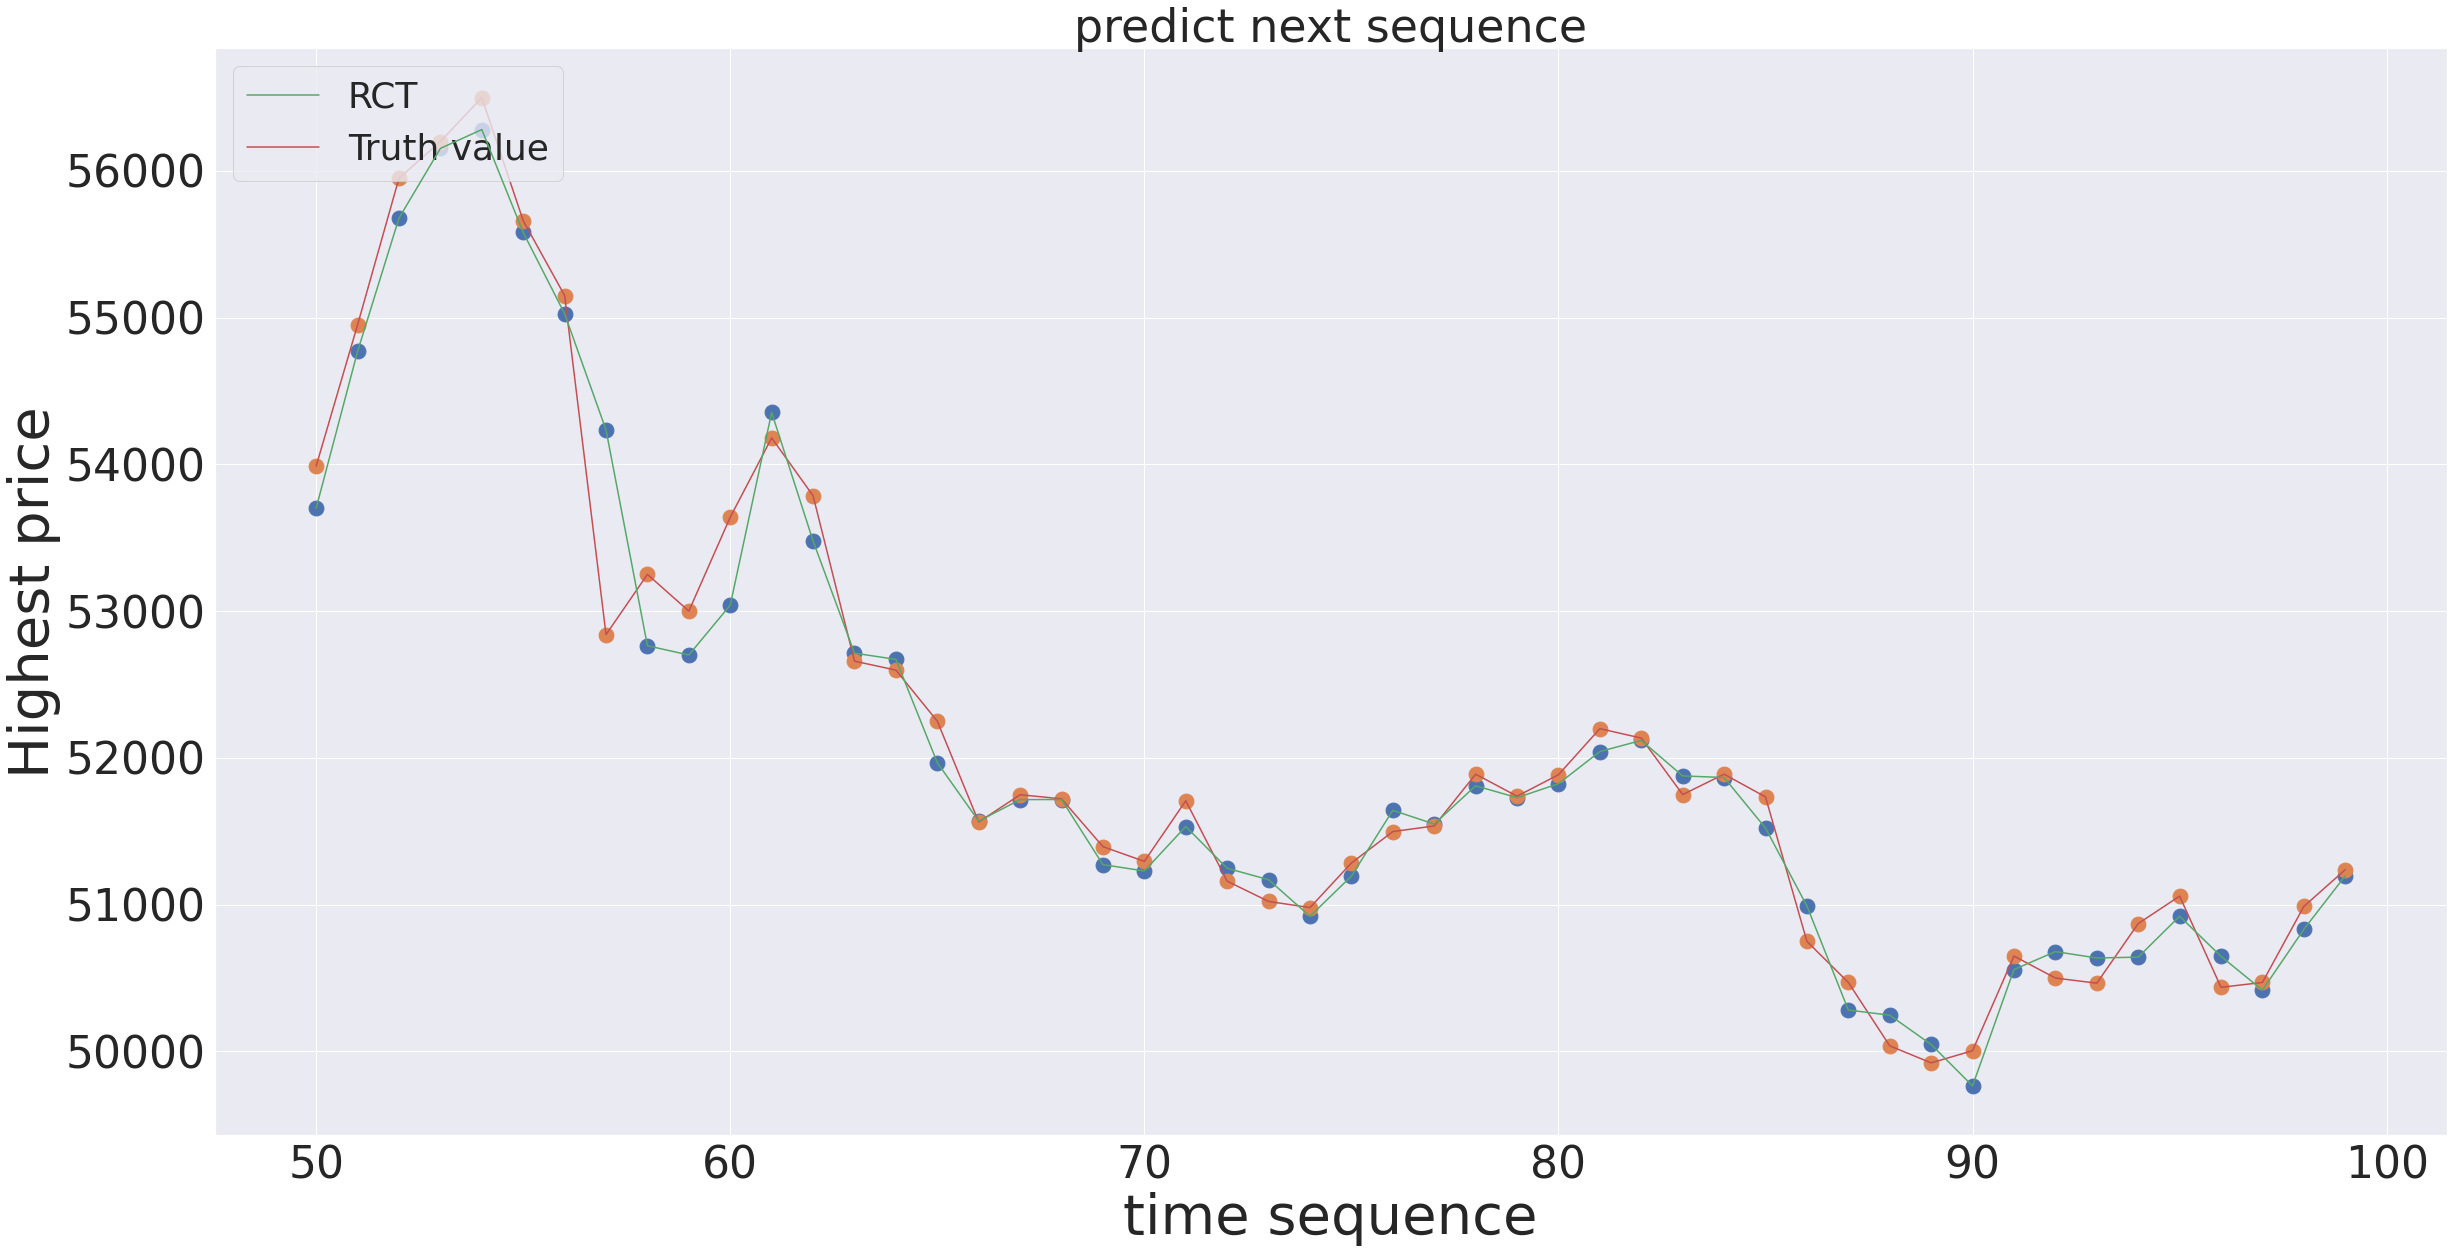

In [67]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 20]
i=50
j=100
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 4)
plt.figure()
plt.plot(xx[i:j],ypred[i:j], color='g', label='RCT', zorder=10)
plt.plot(xx[i:j],y_test1[i:j], color='r', label='Truth value')

plt.scatter(xx[i:j],ypred[i:j],  s=220, zorder=2)
plt.scatter(xx[i:j],y_test1[i:j],  s=220, zorder=2)

plt.legend(loc="upper left", fontsize=36)
plt.title('predict next sequence', fontsize=46)
plt.xlabel('time sequence', fontsize=56)
plt.ylabel('Highest price', fontsize=56)
plt.show()

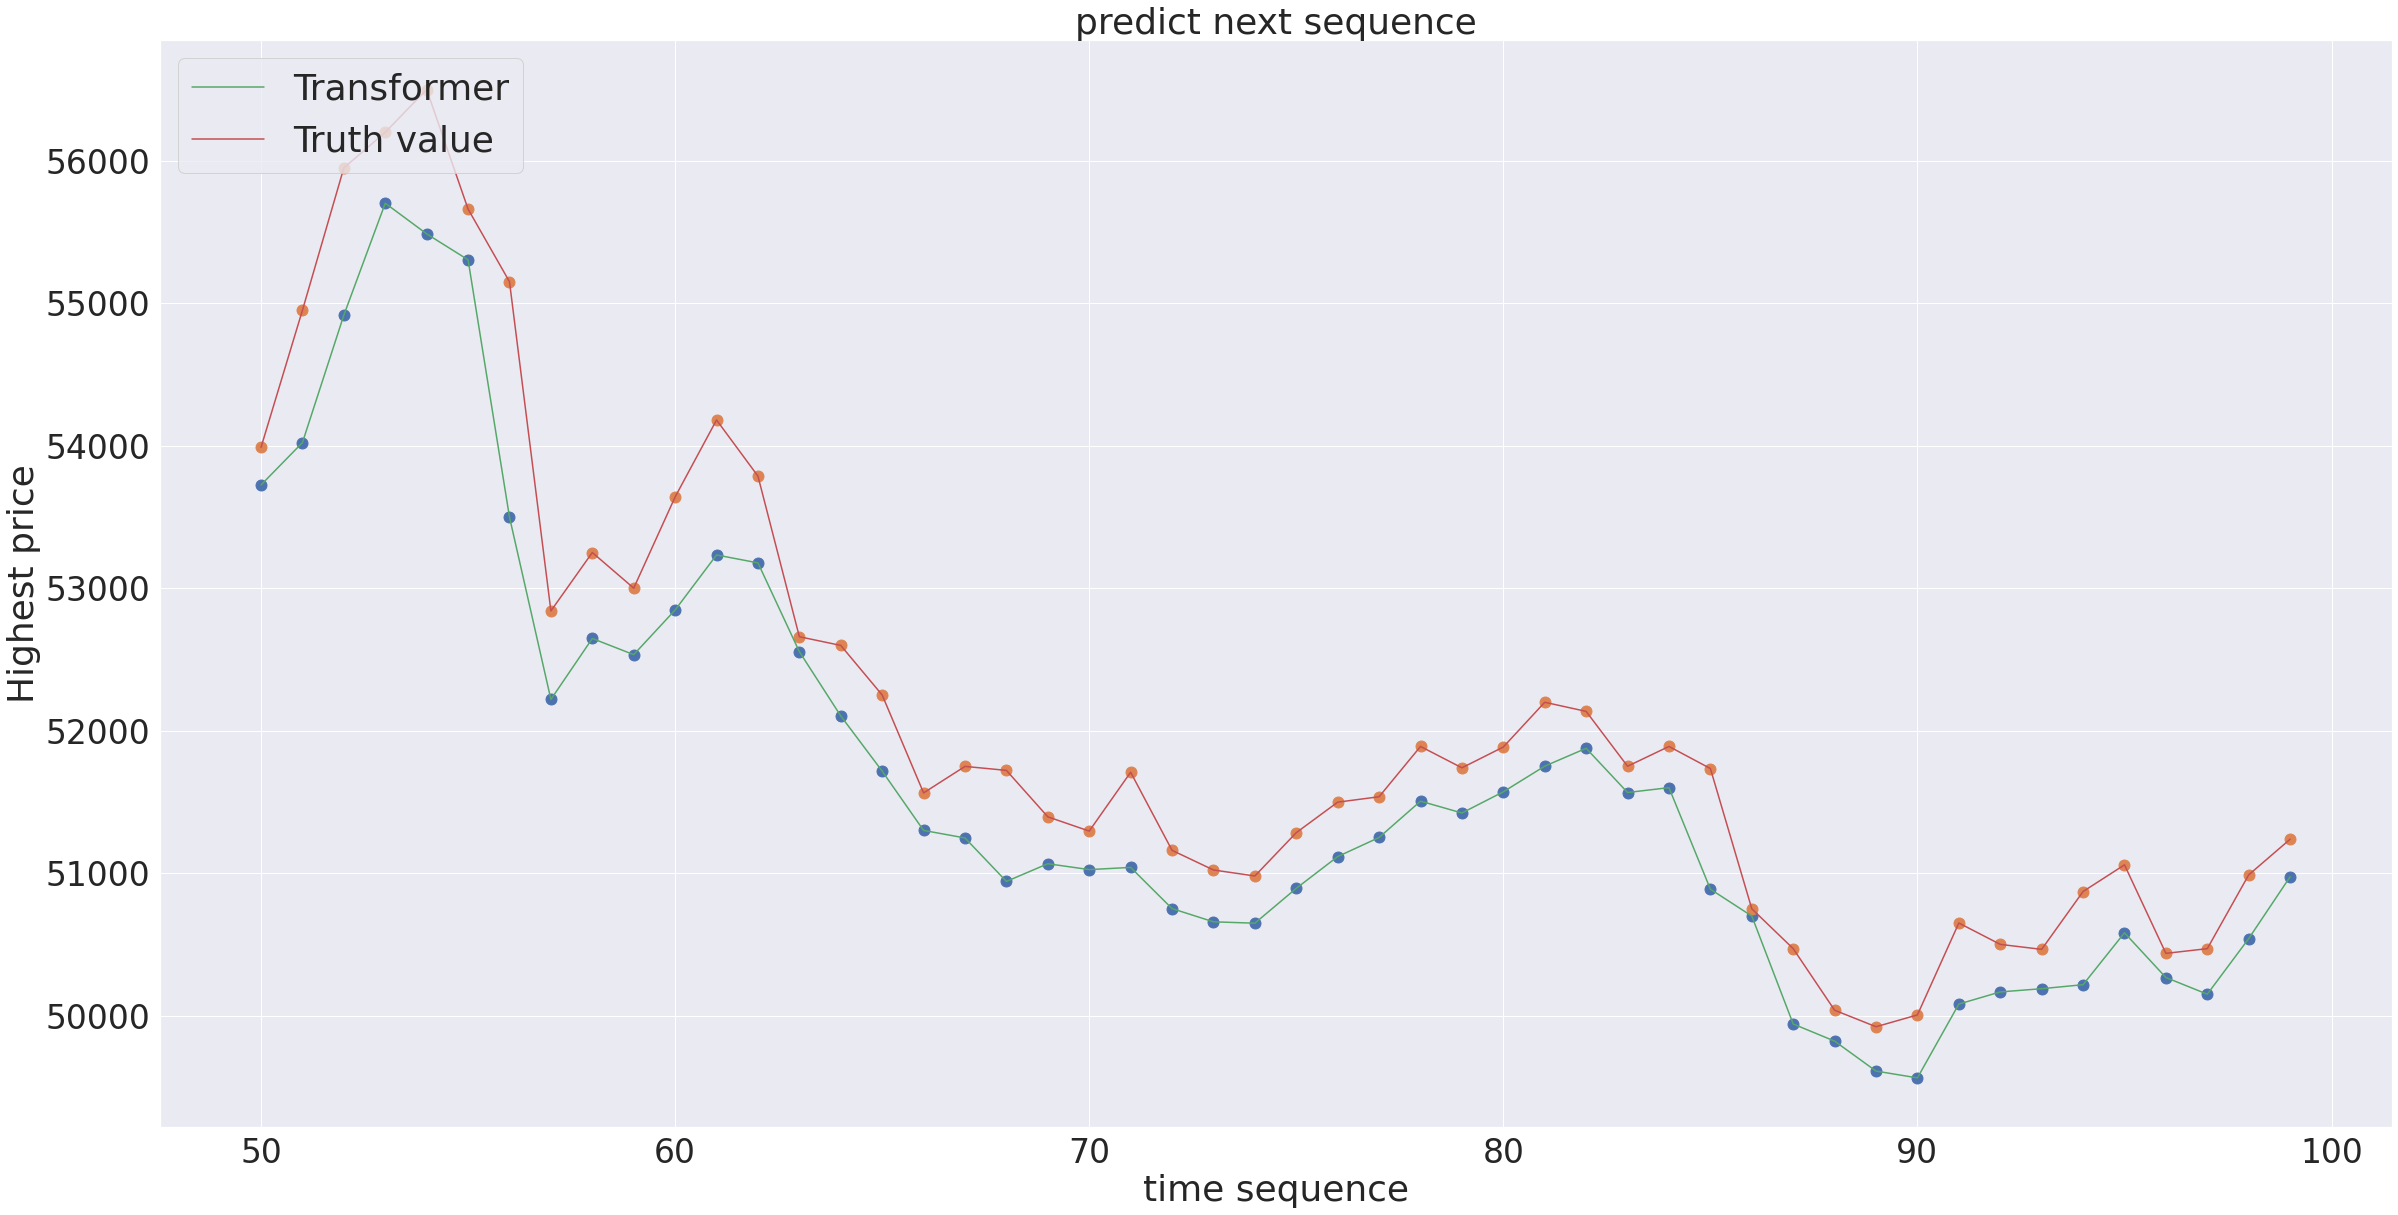

In [66]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 20]
i=50
j=100
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 3)
plt.figure()
plt.plot(xx[i:j],trans_y_predict[i:j], color='g', label='Transformer', zorder=10)
plt.plot(xx[i:j],y_test1[i:j], color='r', label='Truth value')

plt.scatter(xx[i:j],trans_y_predict[i:j],  s=120, zorder=2)
plt.scatter(xx[i:j],y_test1[i:j],  s=120, zorder=2)

plt.legend(loc="upper left", fontsize=36)
plt.title('predict next sequence', fontsize=36)
plt.xlabel('time sequence', fontsize=36)
plt.ylabel('Highest price', fontsize=36)
plt.show()

In [46]:
import pickle
with open('/content/trans_y_predict.pickle', 'rb') as handle:
    trans_y_predict = pickle.load(handle)

with open('/content/trans_x_predict.pickle', 'rb') as handle:
    trans_x_predict = pickle.load(handle)

*** compare for the testing data***

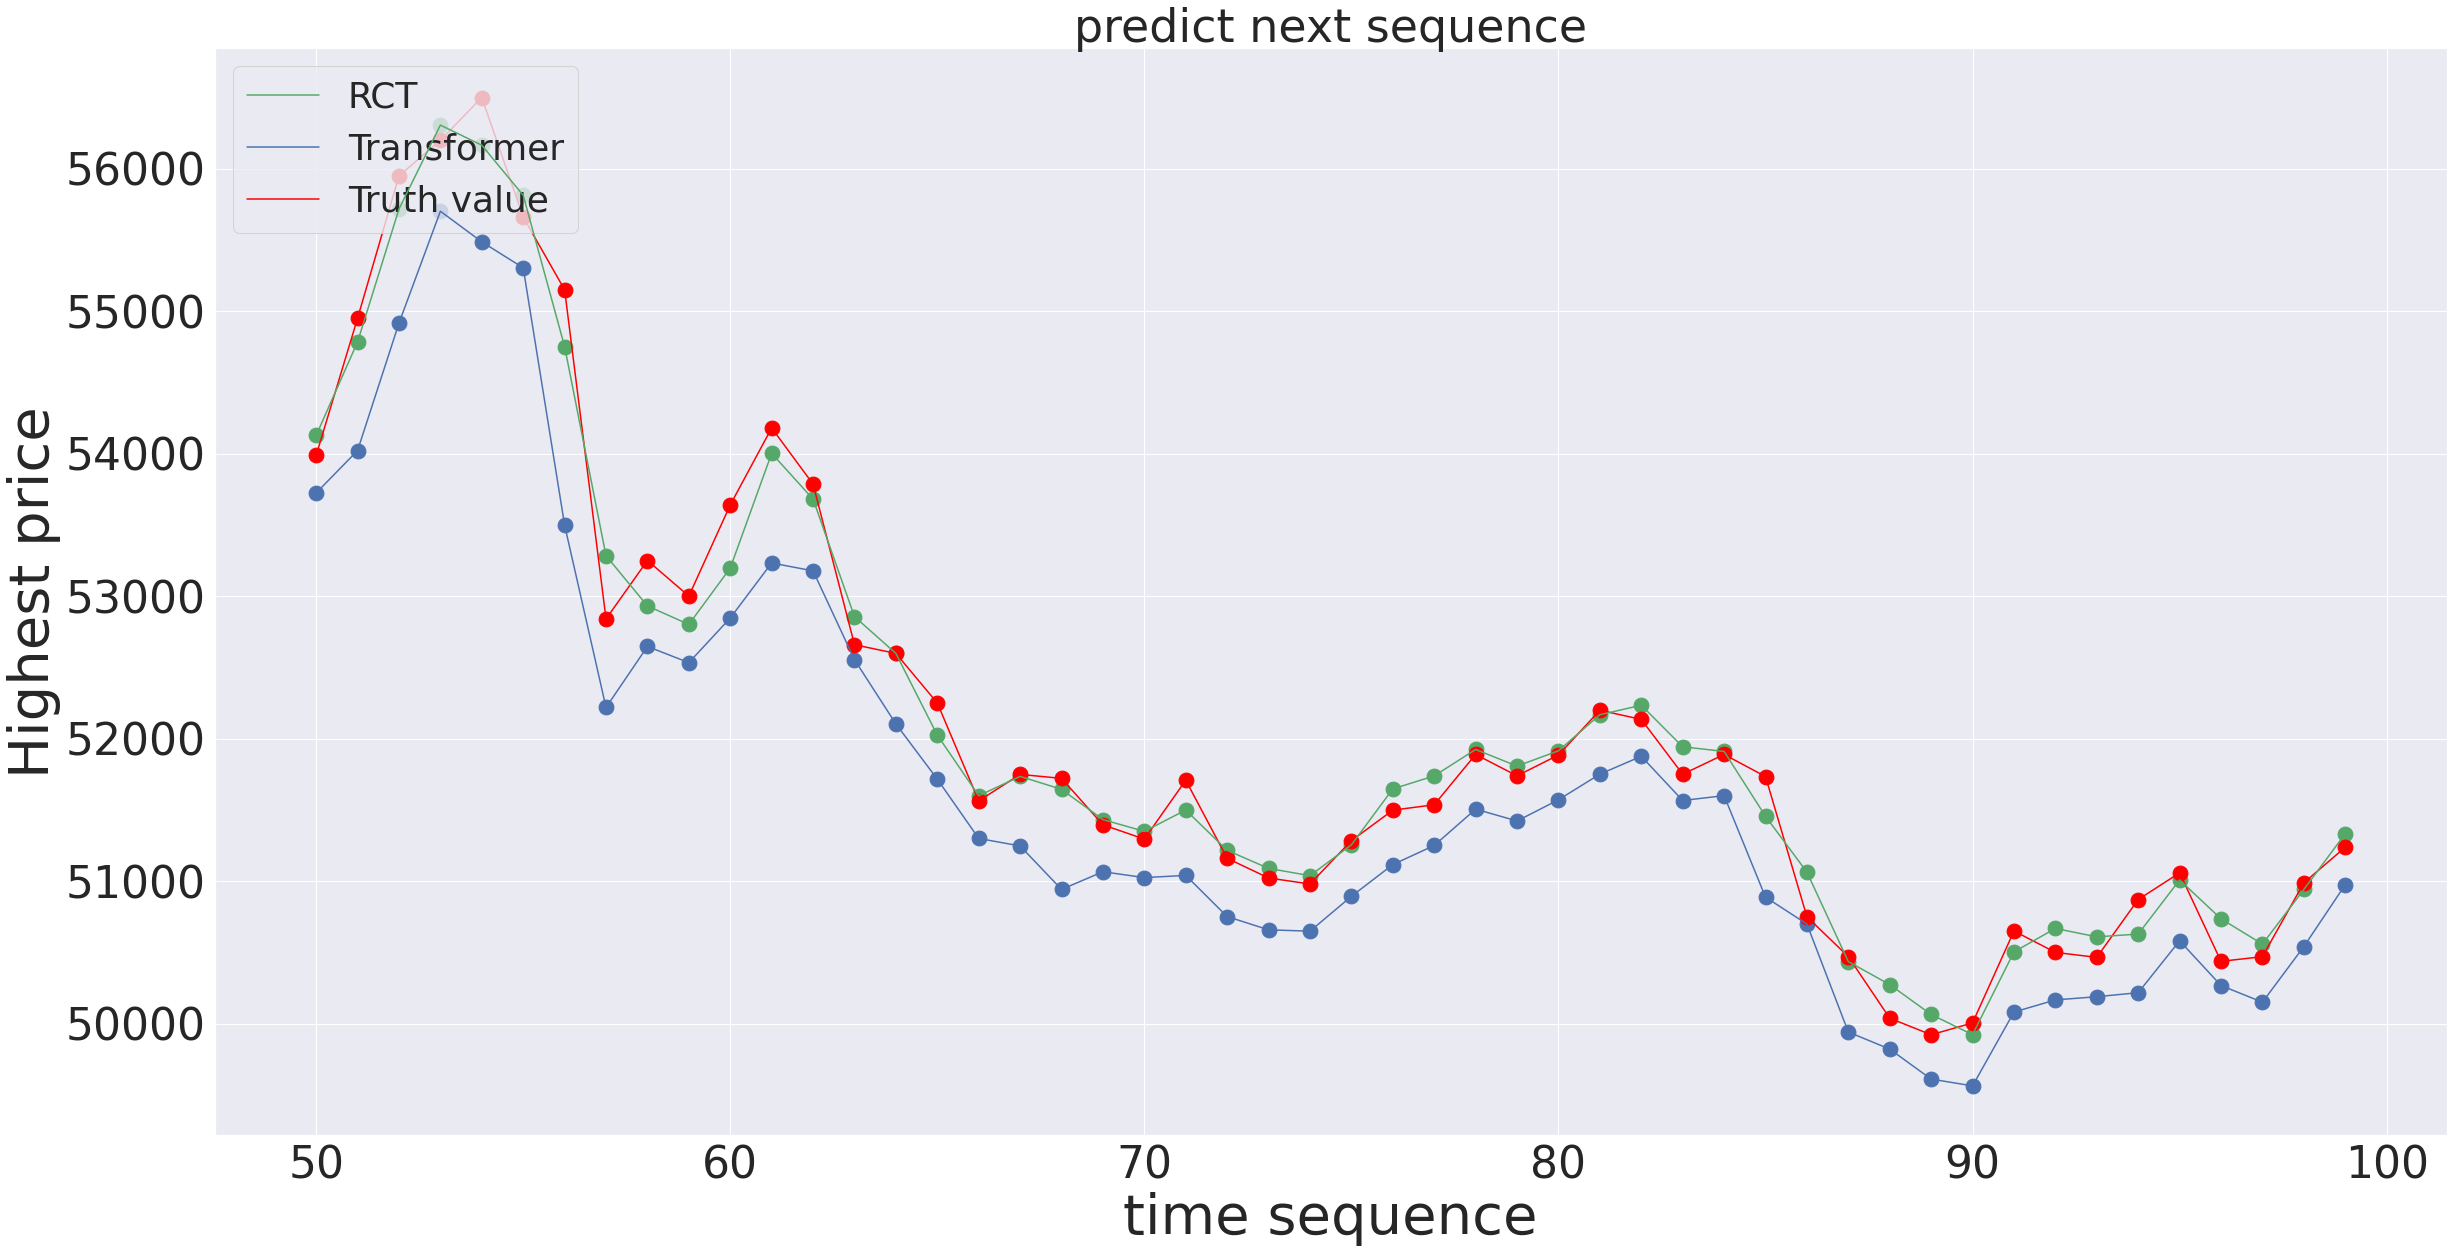

In [72]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 20]
i=50
j=100
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 4)
plt.figure()
plt.plot(xx[i:j],ypred[i:j], color='g', label='RCT', zorder=10)
plt.plot(xx[i:j],trans_y_predict[i:j], color='b', label='Transformer', zorder=10)
plt.plot(xx[i:j],y_test1[i:j], color='red', label='Truth value')

plt.scatter(xx[i:j],ypred[i:j], color='g', s=220, zorder=2)
plt.scatter(xx[i:j],trans_y_predict[i:j], color='b', s=220, zorder=2)
plt.scatter(xx[i:j],y_test1[i:j],  s=220,color='red', zorder=2)

plt.legend(loc="upper left", fontsize=36)
plt.title('predict next sequence', fontsize=46)
plt.xlabel('time sequence', fontsize=56)
plt.ylabel('Highest price', fontsize=56)
plt.show()

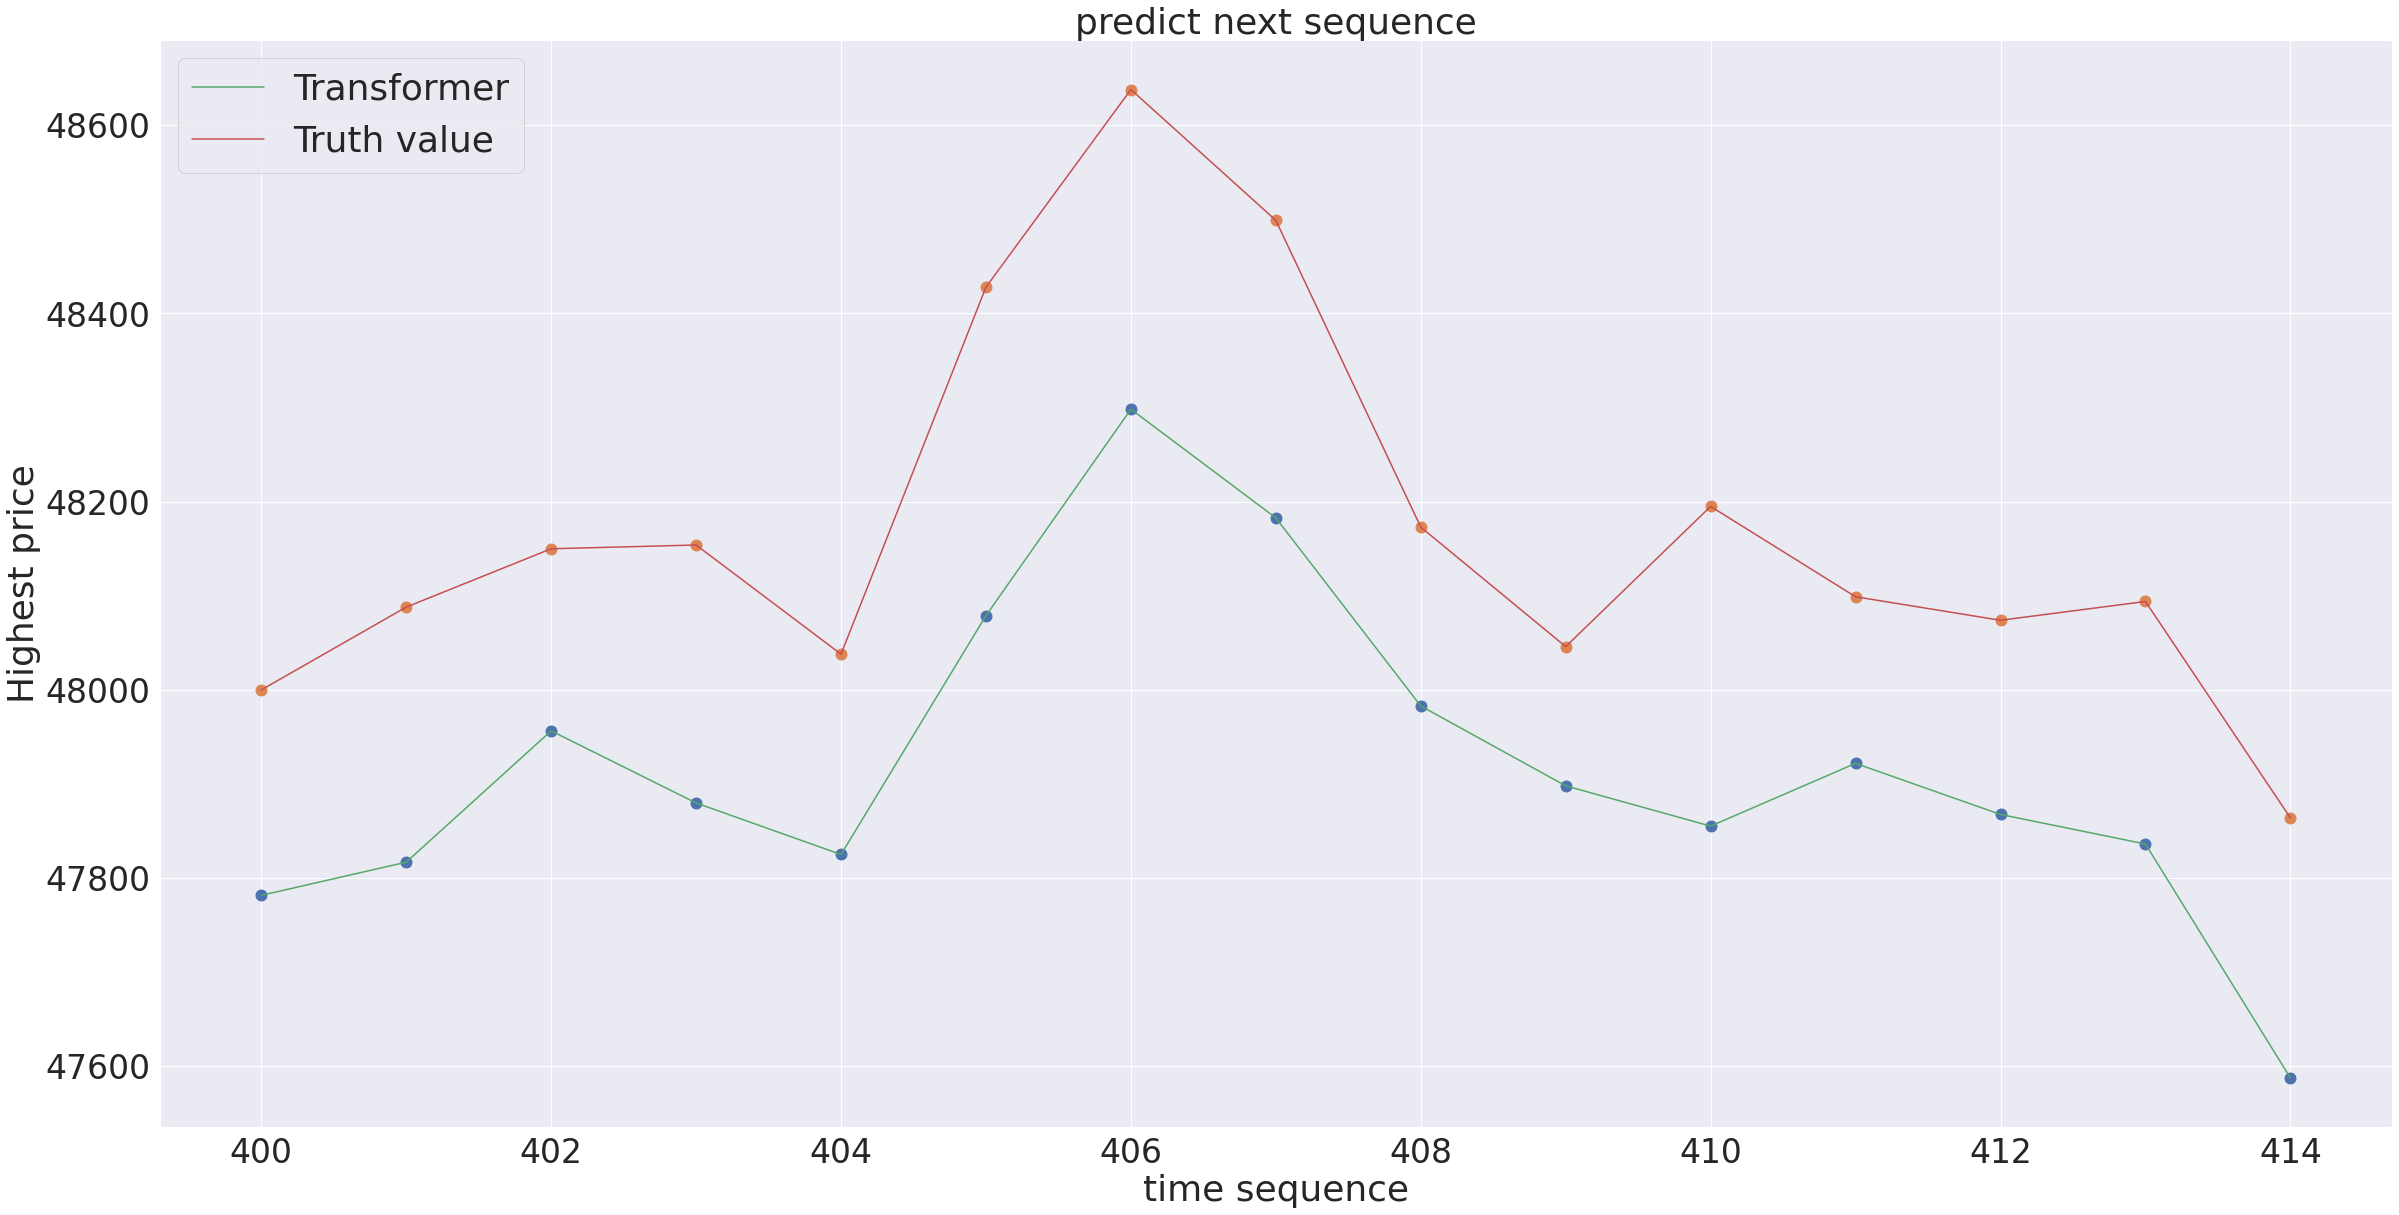

In [64]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 20]
i=400
j=450
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 3)
plt.figure()
plt.plot(xx[i:j],trans_y_predict[i:j], color='g', label='Transformer', zorder=10)
plt.plot(xx[i:j],y_test1[i:j], color='r', label='Truth value')

plt.scatter(xx[i:j],trans_y_predict[i:j],  s=120, zorder=2)
plt.scatter(xx[i:j],y_test1[i:j],  s=120, zorder=2)

plt.legend(loc="upper left", fontsize=36)
plt.title('predict next sequence', fontsize=36)
plt.xlabel('time sequence', fontsize=36)
plt.ylabel('Highest price', fontsize=36)
plt.show()

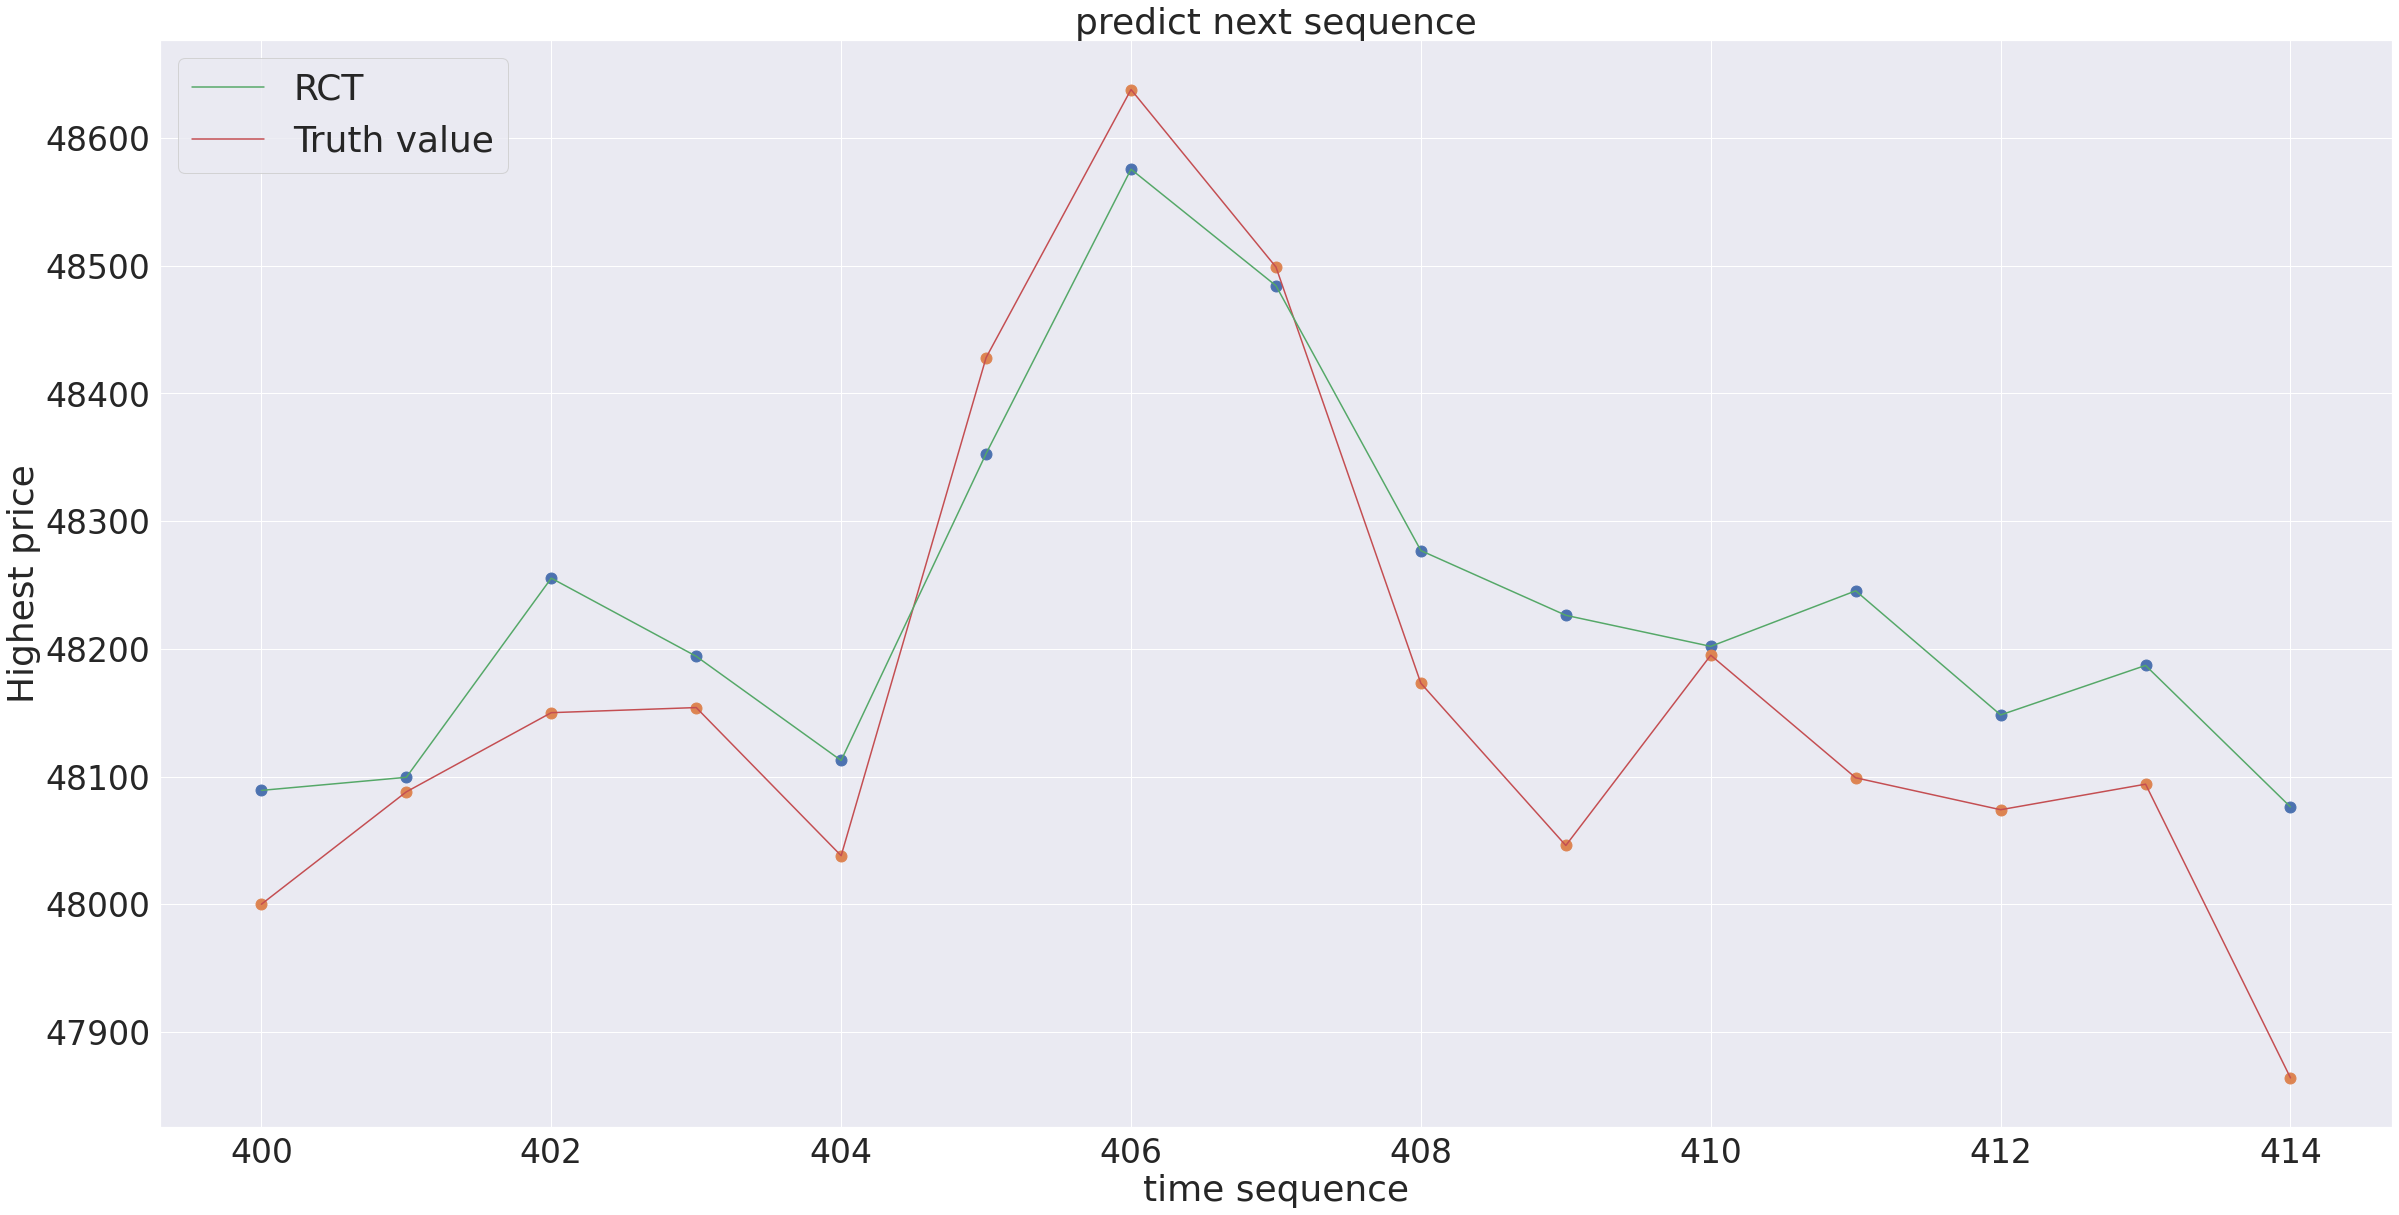

In [63]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 20]
i=400
j=450
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 3)
plt.figure()
plt.plot(xx[i:j],ypred[i:j], color='g', label='RCT', zorder=10)
plt.plot(xx[i:j],y_test1[i:j], color='r', label='Truth value')

plt.scatter(xx[i:j],ypred[i:j],  s=120, zorder=2)
plt.scatter(xx[i:j],y_test1[i:j],  s=120, zorder=2)

plt.legend(loc="upper left", fontsize=36)
plt.title('predict next sequence', fontsize=36)
plt.xlabel('time sequence', fontsize=36)
plt.ylabel('Highest price', fontsize=36)
plt.show()

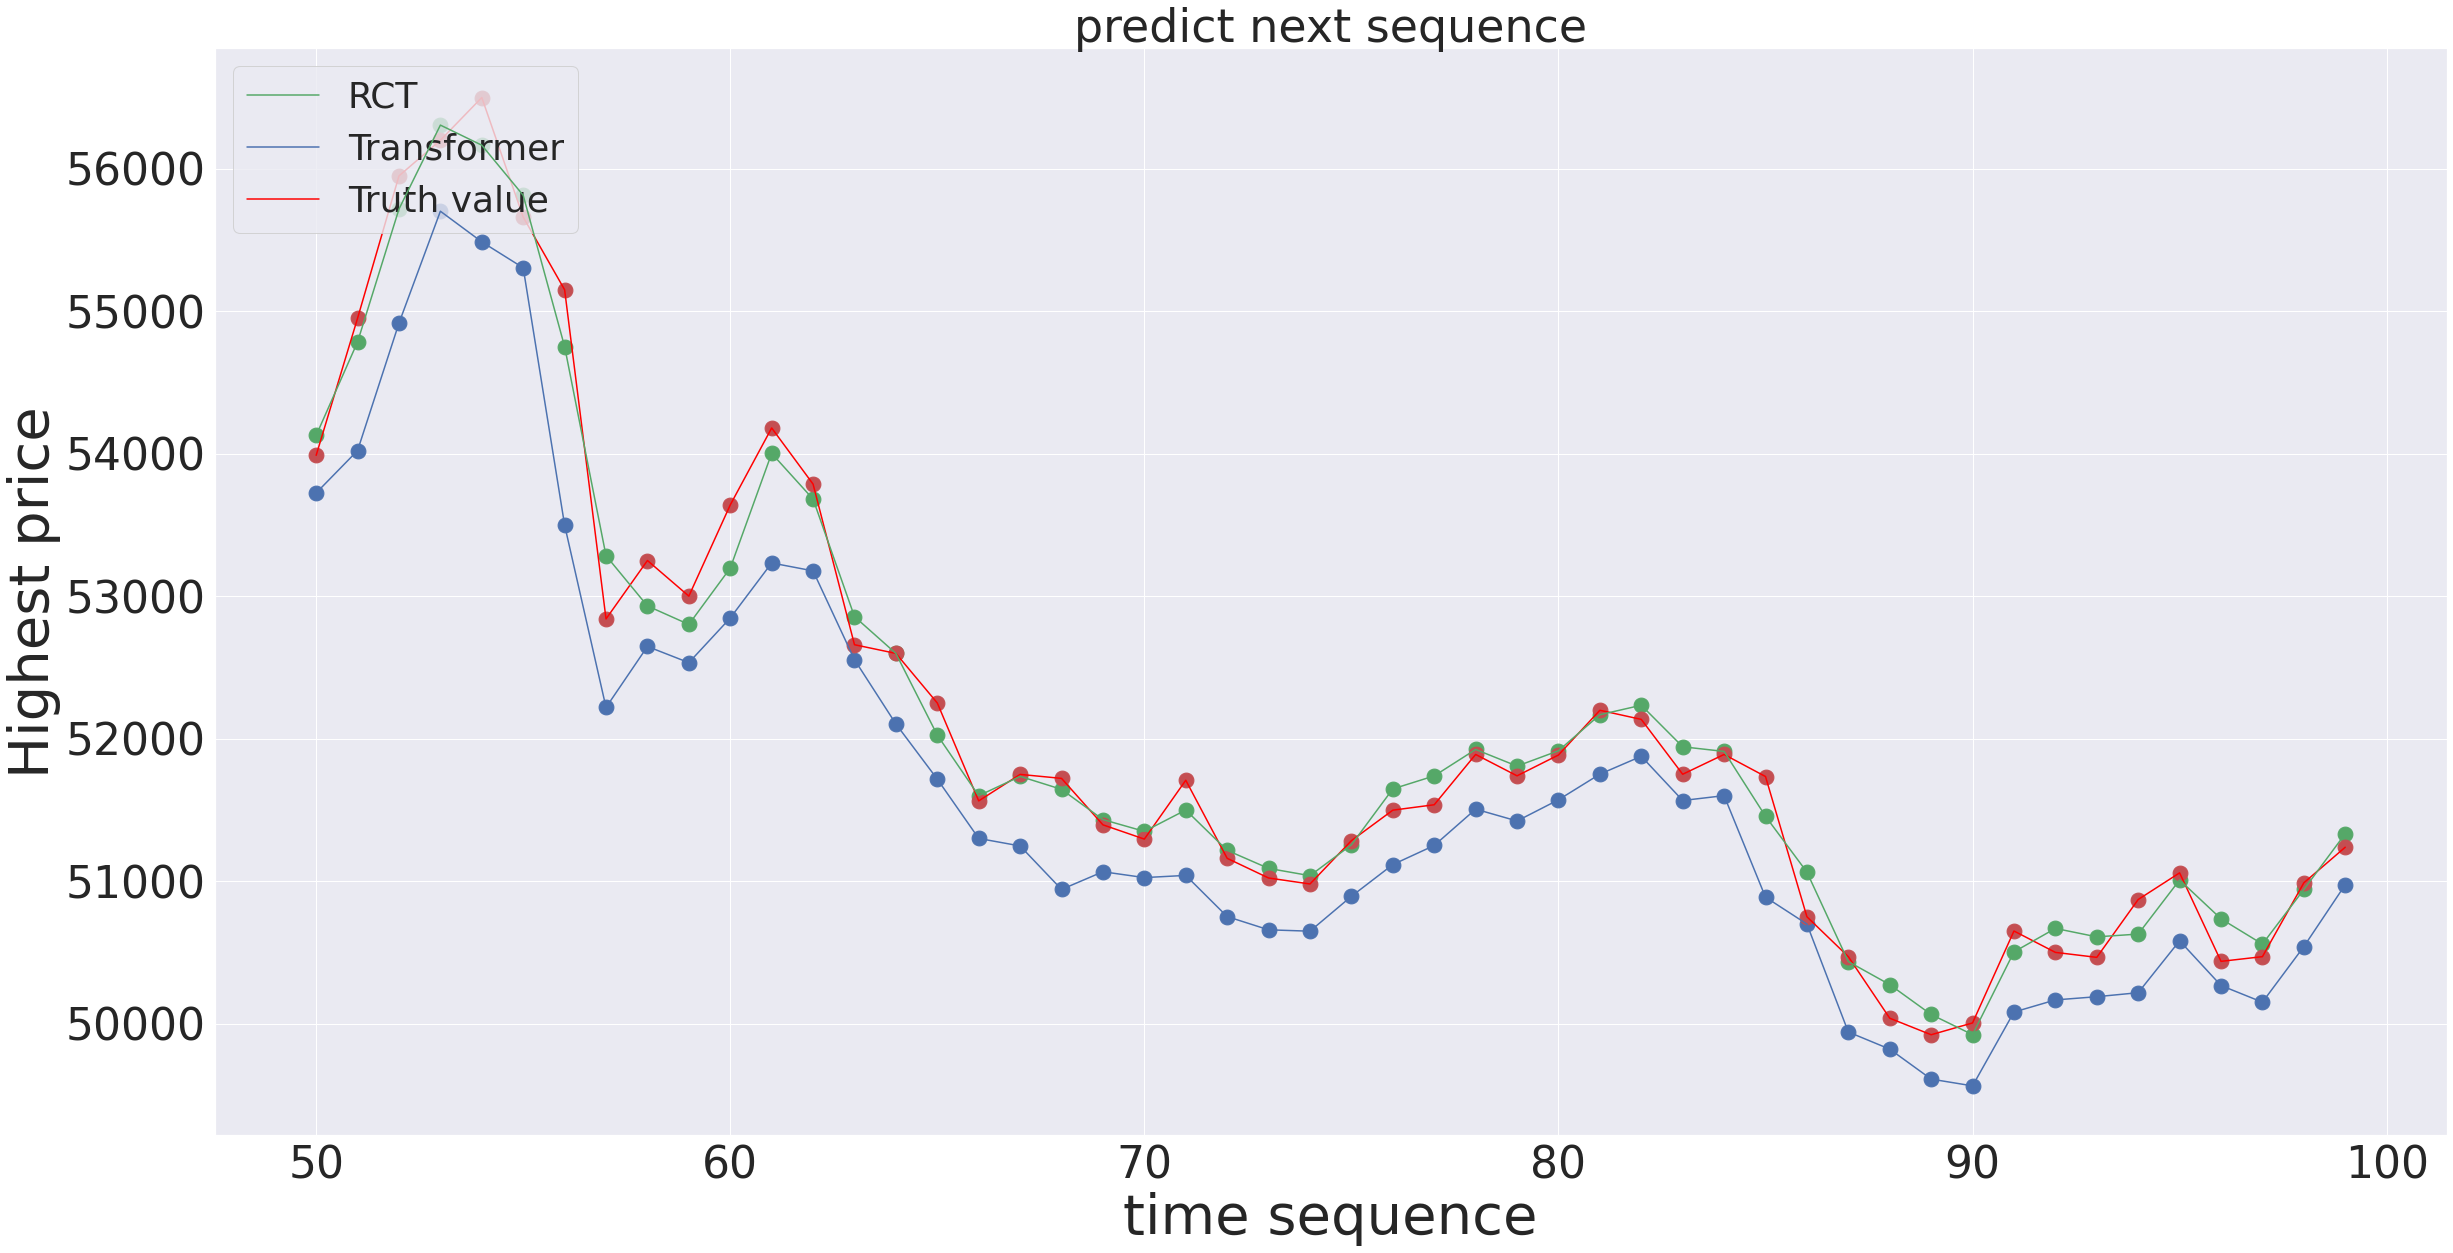

In [73]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 20]
i=50
j=100
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 4)
plt.figure()
plt.plot(xx[i:j],ypred[i:j], color='g', label='RCT', zorder=10)
plt.plot(xx[i:j],trans_y_predict[i:j], color='b', label='Transformer', zorder=10)
plt.plot(xx[i:j],y_test1[i:j], color='red', label='Truth value')

plt.scatter(xx[i:j],ypred[i:j], color='g', s=220, zorder=2)
plt.scatter(xx[i:j],trans_y_predict[i:j], color='b', s=220, zorder=2)
plt.scatter(xx[i:j],y_test1[i:j],  s=220,color='r', zorder=2)

plt.legend(loc="upper left", fontsize=36)
plt.title('predict next sequence', fontsize=46)
plt.xlabel('time sequence', fontsize=56)
plt.ylabel('Highest price', fontsize=56)
plt.show()

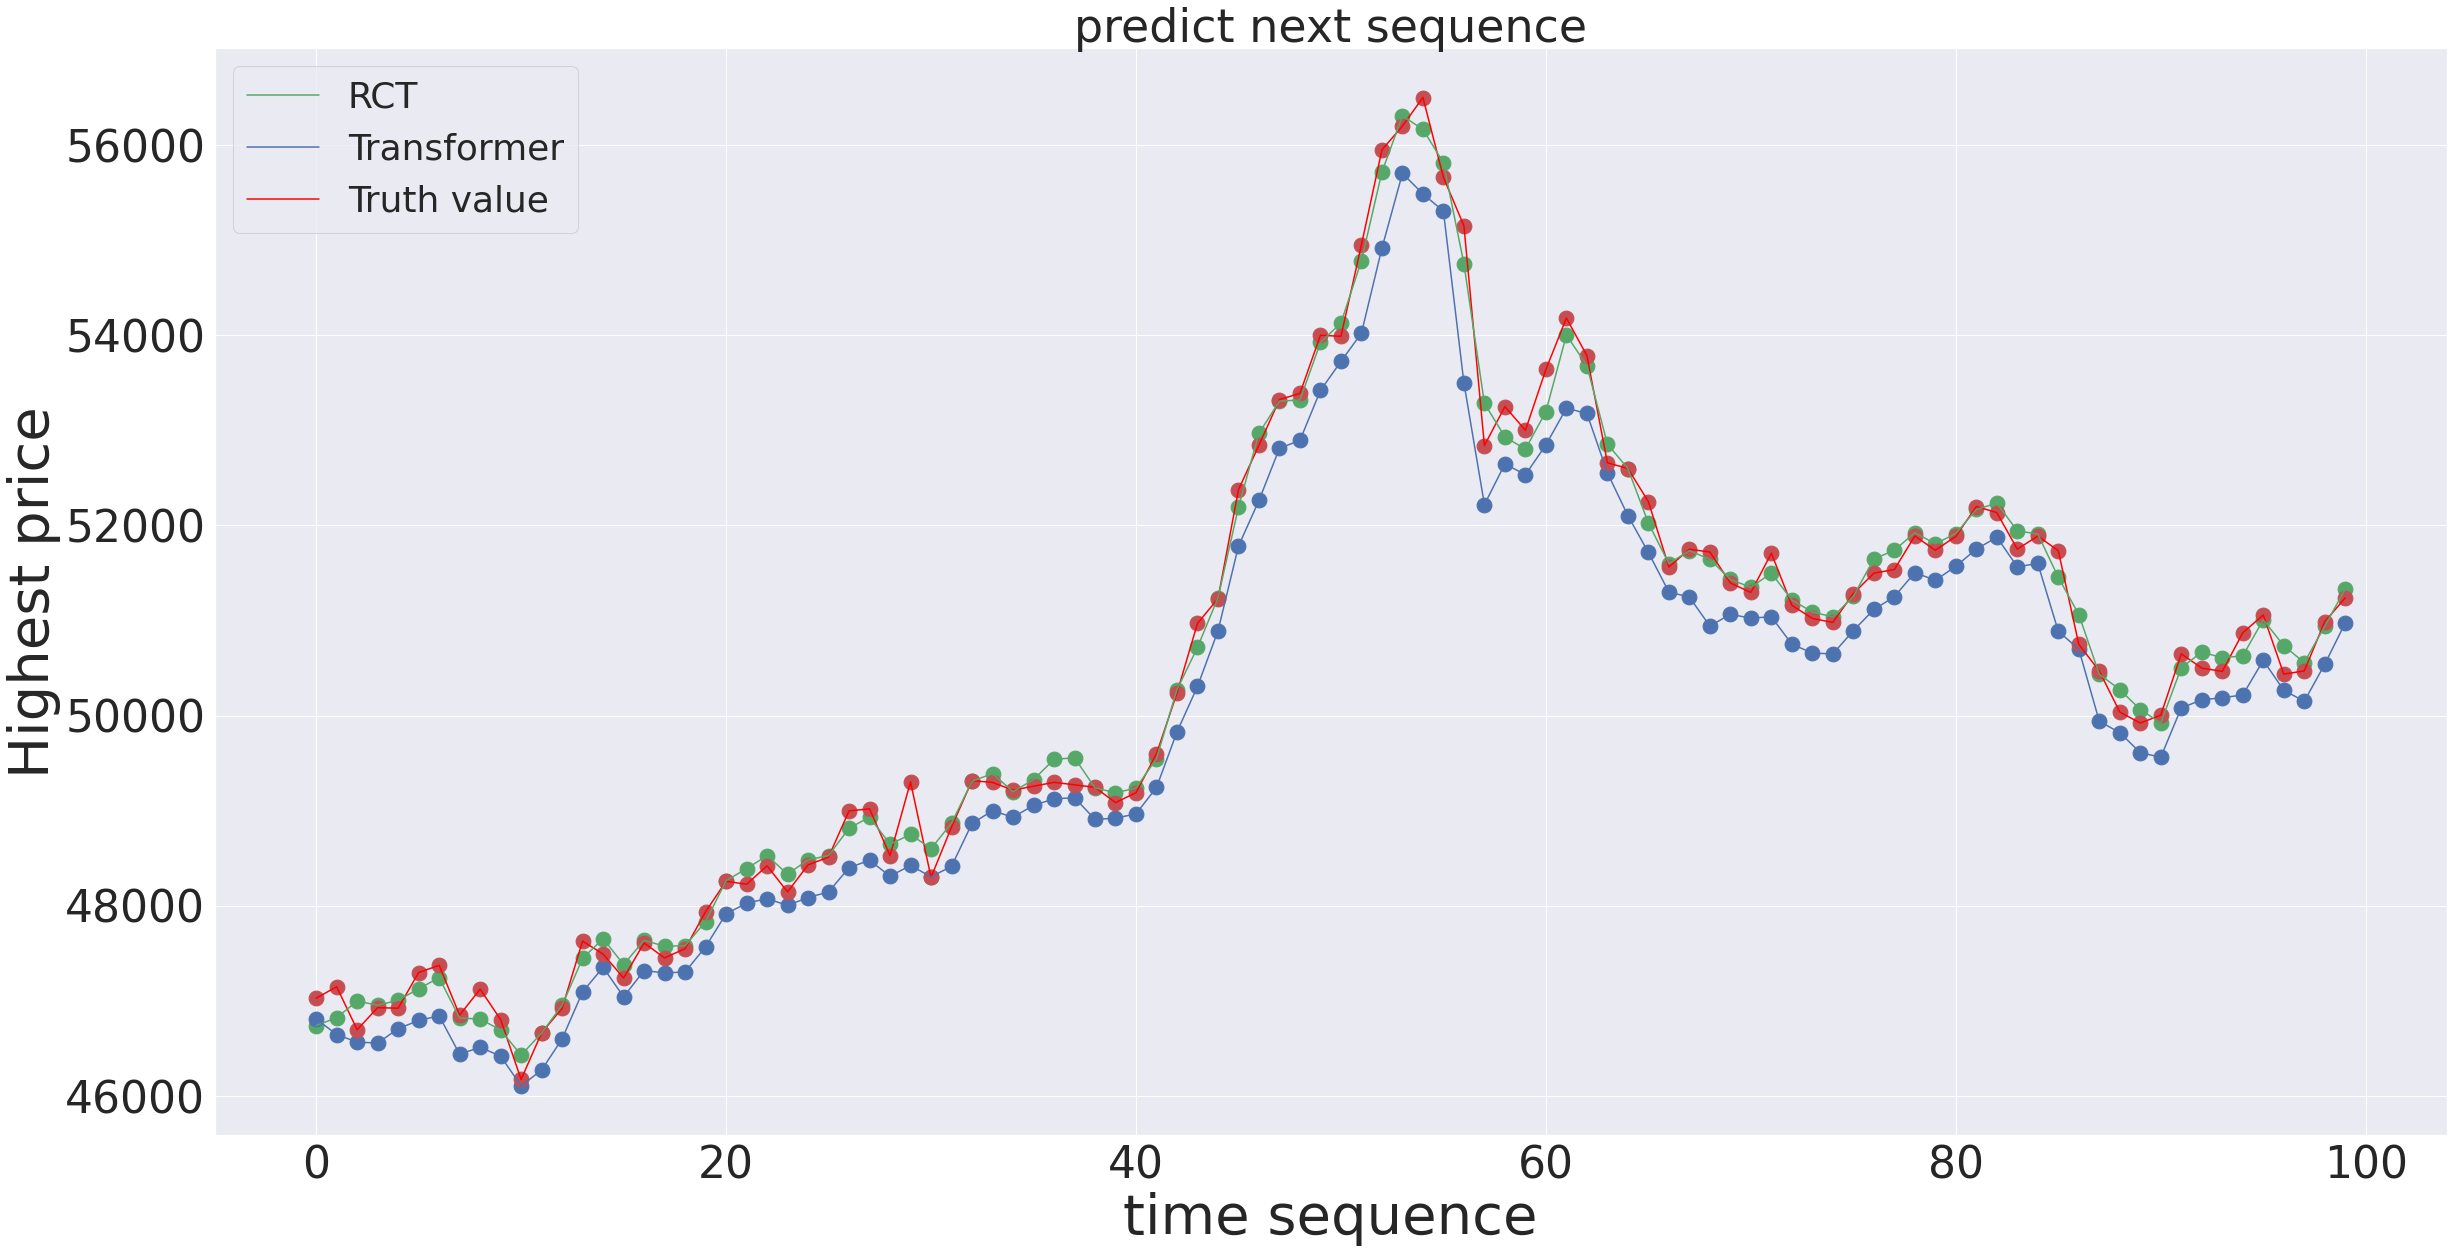

In [74]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 20]
i=0
j=100
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 4)
plt.figure()
plt.plot(xx[i:j],ypred[i:j], color='g', label='RCT', zorder=10)
plt.plot(xx[i:j],trans_y_predict[i:j], color='b', label='Transformer', zorder=10)
plt.plot(xx[i:j],y_test1[i:j], color='red', label='Truth value')

plt.scatter(xx[i:j],ypred[i:j], color='g', s=220, zorder=2)
plt.scatter(xx[i:j],trans_y_predict[i:j], color='b', s=220, zorder=2)
plt.scatter(xx[i:j],y_test1[i:j],  s=220,color='r', zorder=2)

plt.legend(loc="upper left", fontsize=36)
plt.title('predict next sequence', fontsize=46)
plt.xlabel('time sequence', fontsize=56)
plt.ylabel('Highest price', fontsize=56)
plt.show()

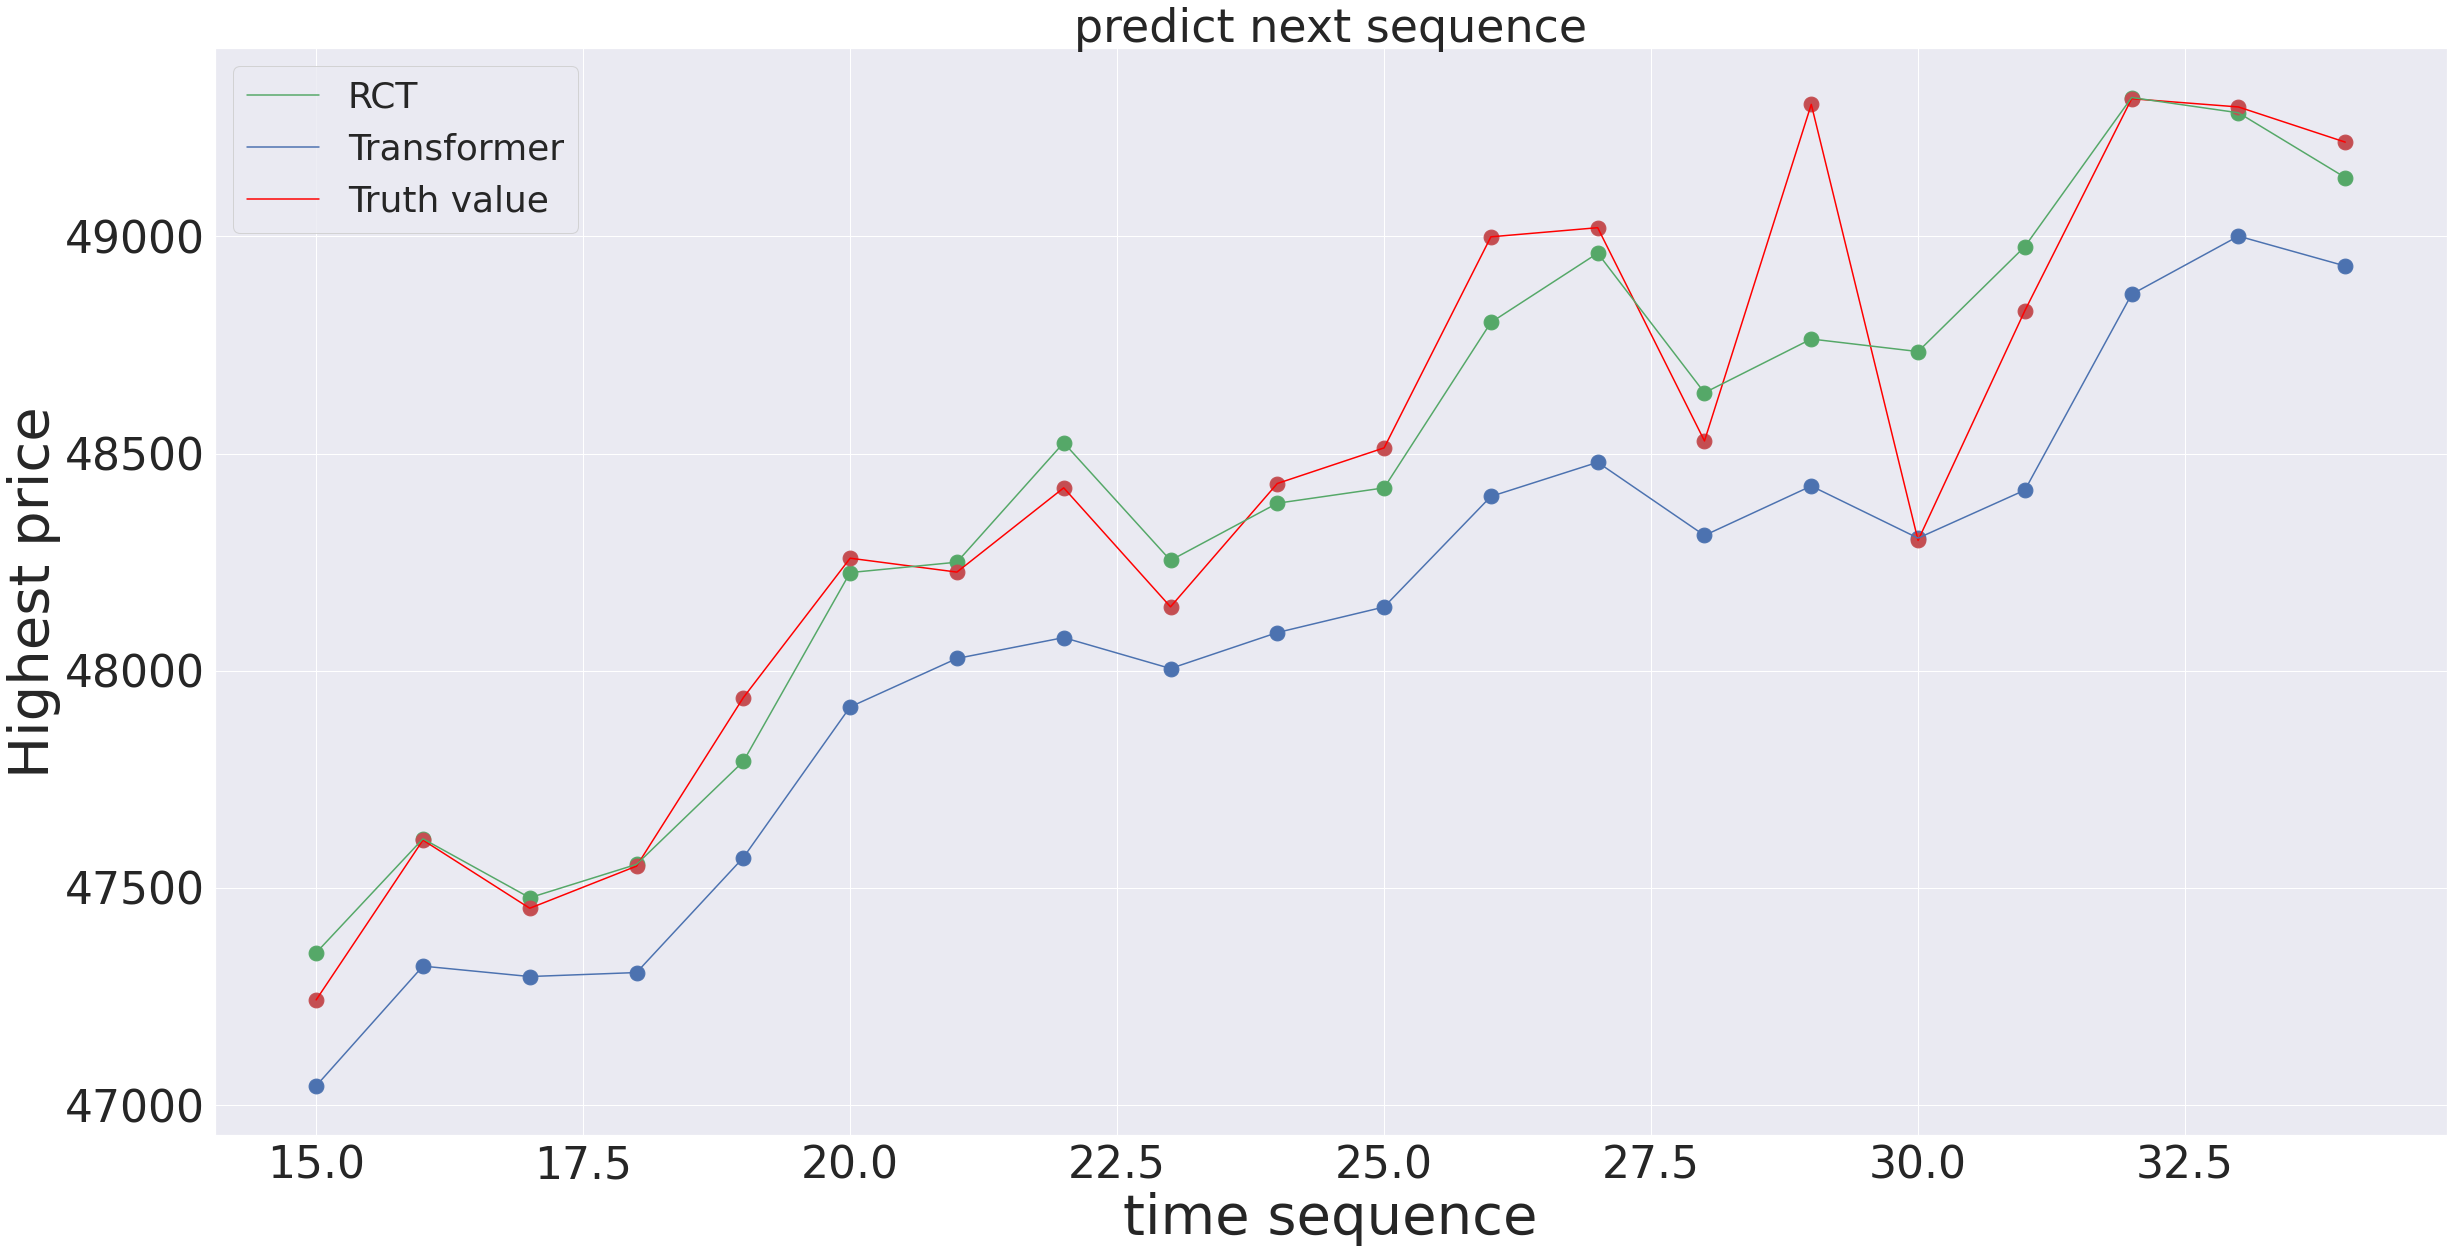

In [60]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 20]
i=15
j=35
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 4)
plt.figure()
plt.plot(xx[i:j],ypred[i:j], color='g', label='RCT', zorder=10)
plt.plot(xx[i:j],trans_y_predict[i:j], color='b', label='Transformer', zorder=10)
plt.plot(xx[i:j],y_test1[i:j], color='red', label='Truth value')

plt.scatter(xx[i:j],ypred[i:j], color='g', s=220, zorder=2)
plt.scatter(xx[i:j],trans_y_predict[i:j], color='b', s=220, zorder=2)
plt.scatter(xx[i:j],y_test1[i:j],  s=220,color='r', zorder=2)

plt.legend(loc="upper left", fontsize=36)
plt.title('predict next sequence', fontsize=46)
plt.xlabel('time sequence', fontsize=56)
plt.ylabel('Highest price', fontsize=56)
plt.show()

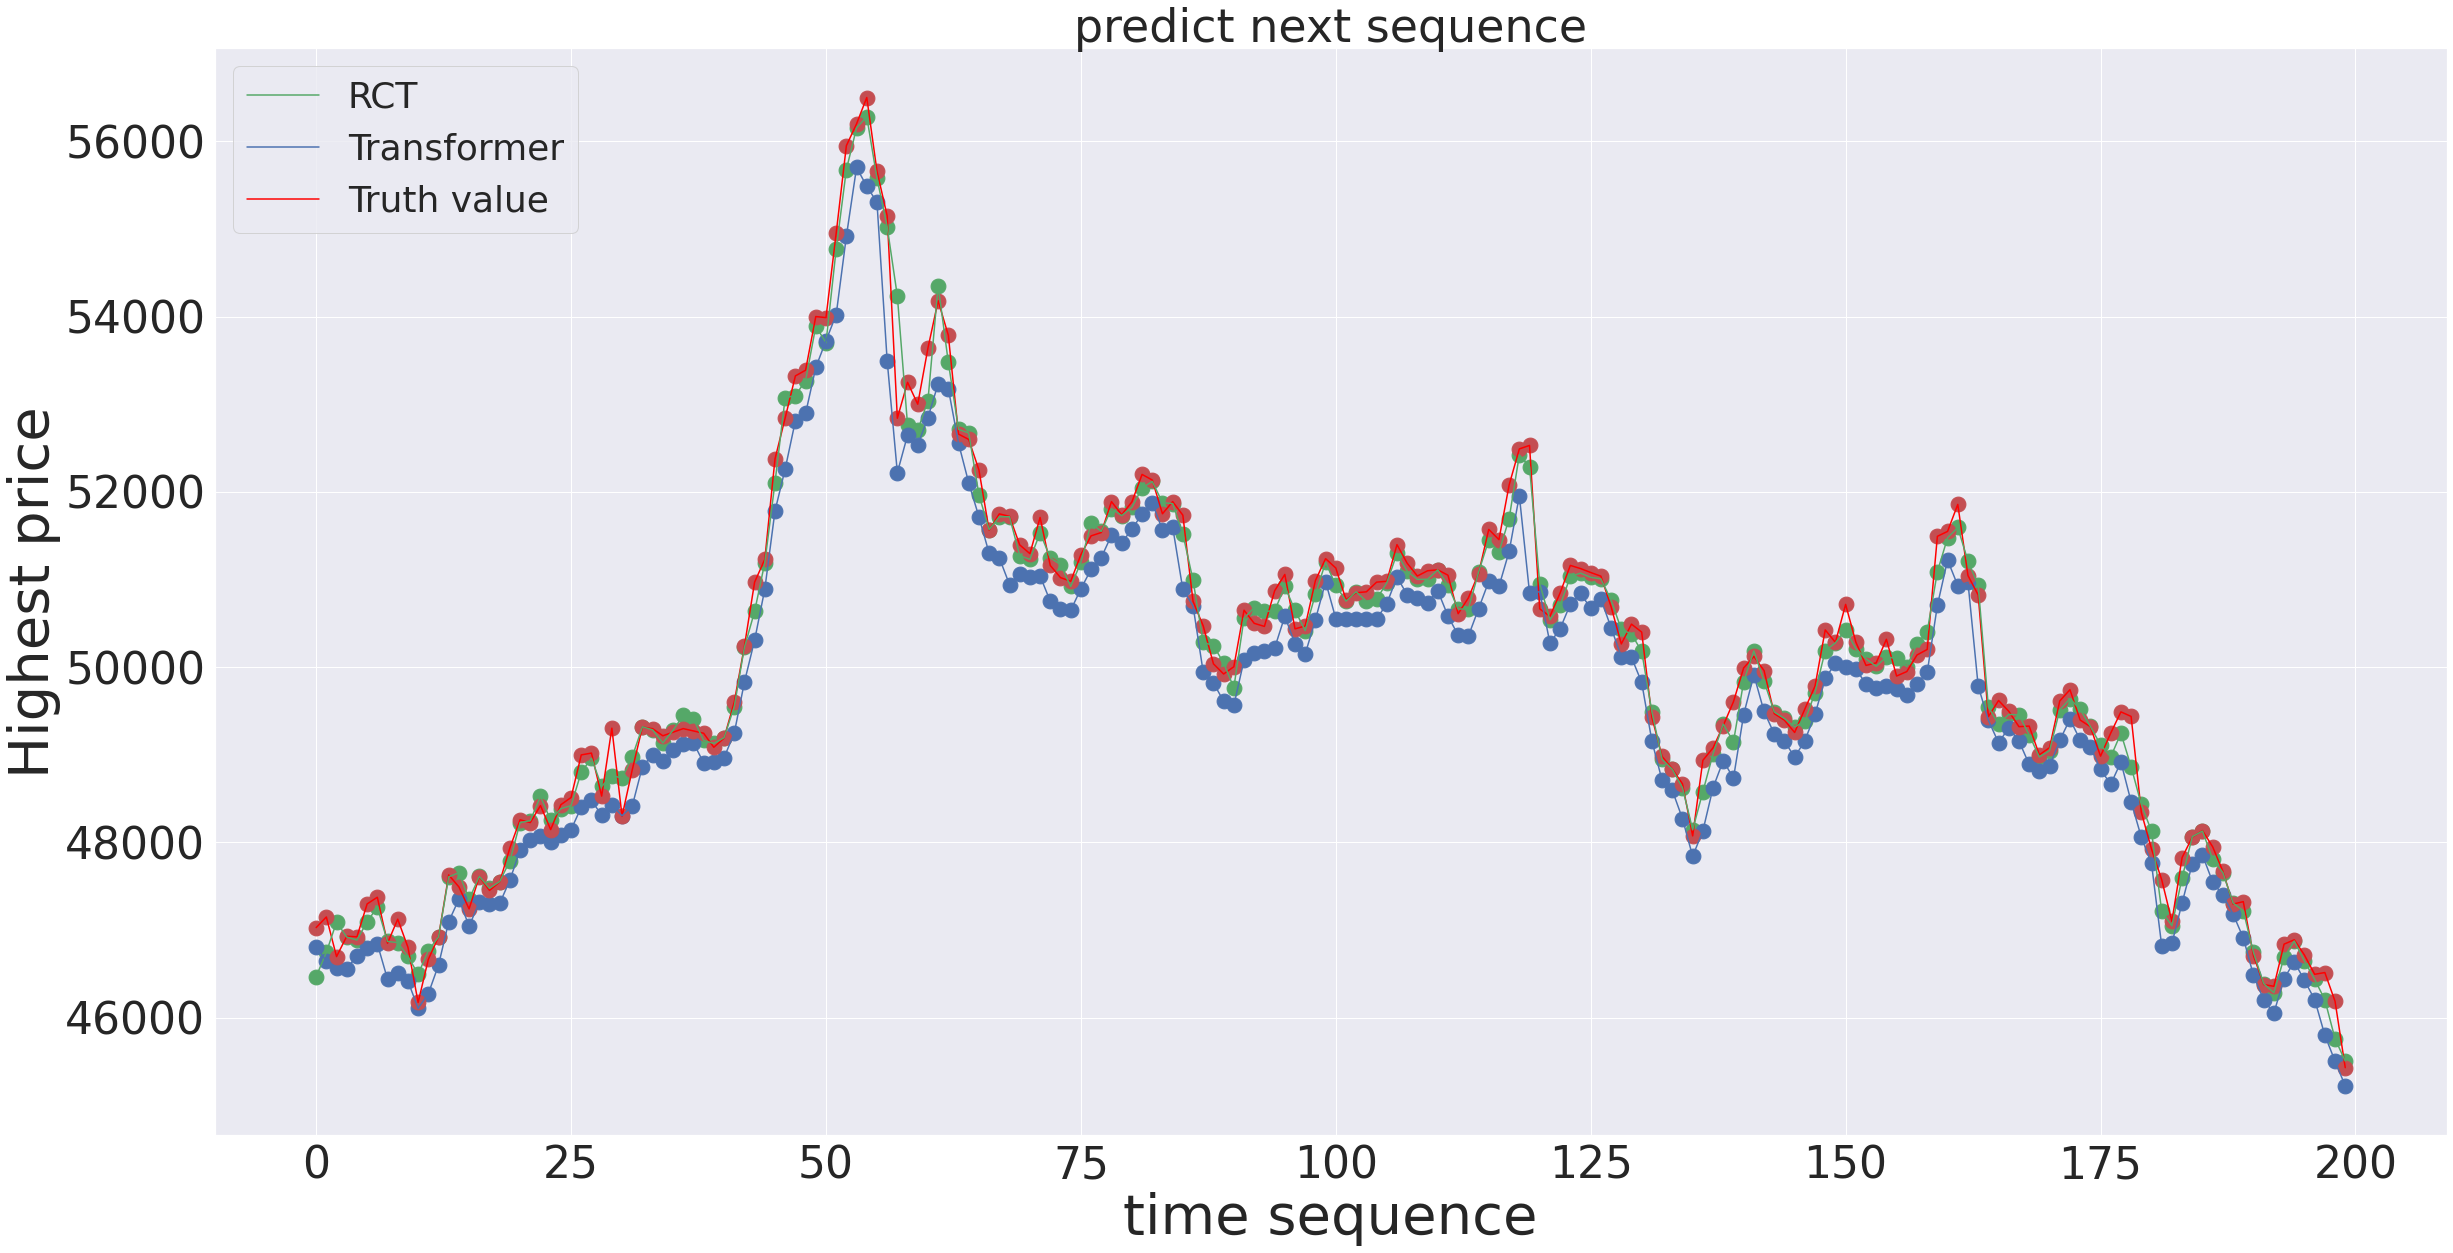

In [59]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 20]
i=0
j=200
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 4)
plt.figure()
plt.plot(xx[i:j],ypred[i:j], color='g', label='RCT', zorder=10)
plt.plot(xx[i:j],trans_y_predict[i:j], color='b', label='Transformer', zorder=10)
plt.plot(xx[i:j],y_test1[i:j], color='red', label='Truth value')

plt.scatter(xx[i:j],ypred[i:j], color='g', s=220, zorder=2)
plt.scatter(xx[i:j],trans_y_predict[i:j], color='b', s=220, zorder=2)
plt.scatter(xx[i:j],y_test1[i:j],  s=220,color='r', zorder=2)

plt.legend(loc="upper left", fontsize=36)
plt.title('predict next sequence', fontsize=46)
plt.xlabel('time sequence', fontsize=56)
plt.ylabel('Highest price', fontsize=56)
plt.show()

In [ ]:
len(ypred)

5636

* compare for the trainig data


ValueError: ignored

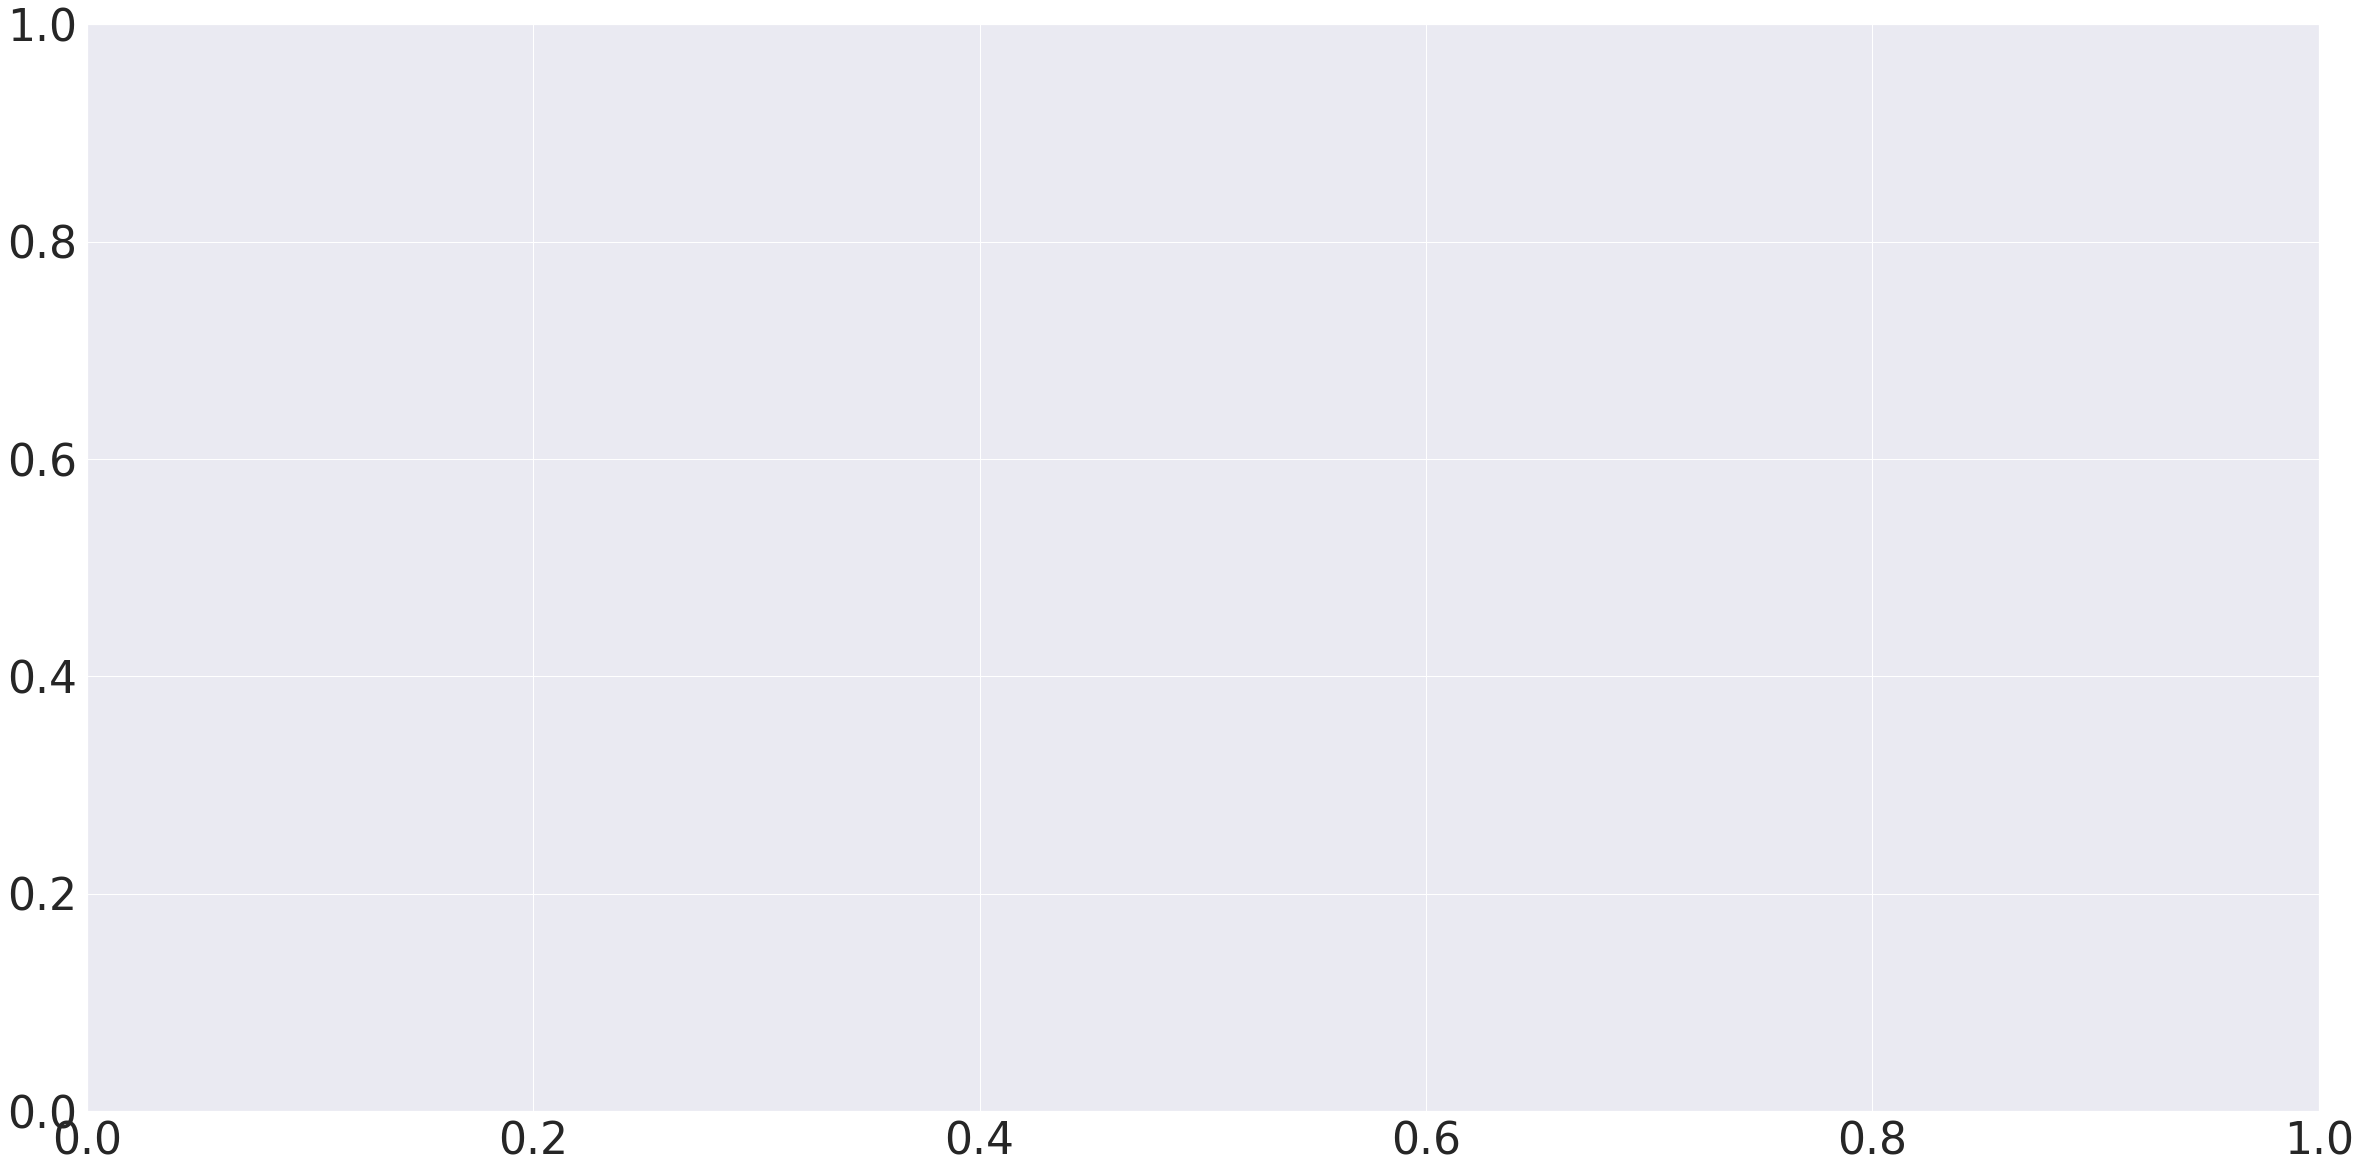

In [57]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 20]
i=0
j=5000
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 4)
plt.figure()
plt.plot(xx[i:j],xpred[i:j], color='g', label='RCT', zorder=10)
plt.plot(xx[i:j],trans_x_predict[i:j], color='b', label='Transformer', zorder=10)
plt.plot(xx[i:j],y_train1[i:j], color='red', label='Turth value')

plt.scatter(xx[i:j],xpred[i:j], color='g', s=220, zorder=2)
plt.scatter(xx[i:j],trans_x_predict[i:j], color='b', s=220, zorder=2)
plt.scatter(xx[i:j],y_train1[i:j],  s=220, color='red', zorder=2)

plt.legend(loc="upper left", fontsize=36)
plt.title('predict next sequence', fontsize=46)
plt.xlabel('time sequence', fontsize=56)
plt.ylabel('Highest price', fontsize=56)
plt.show()

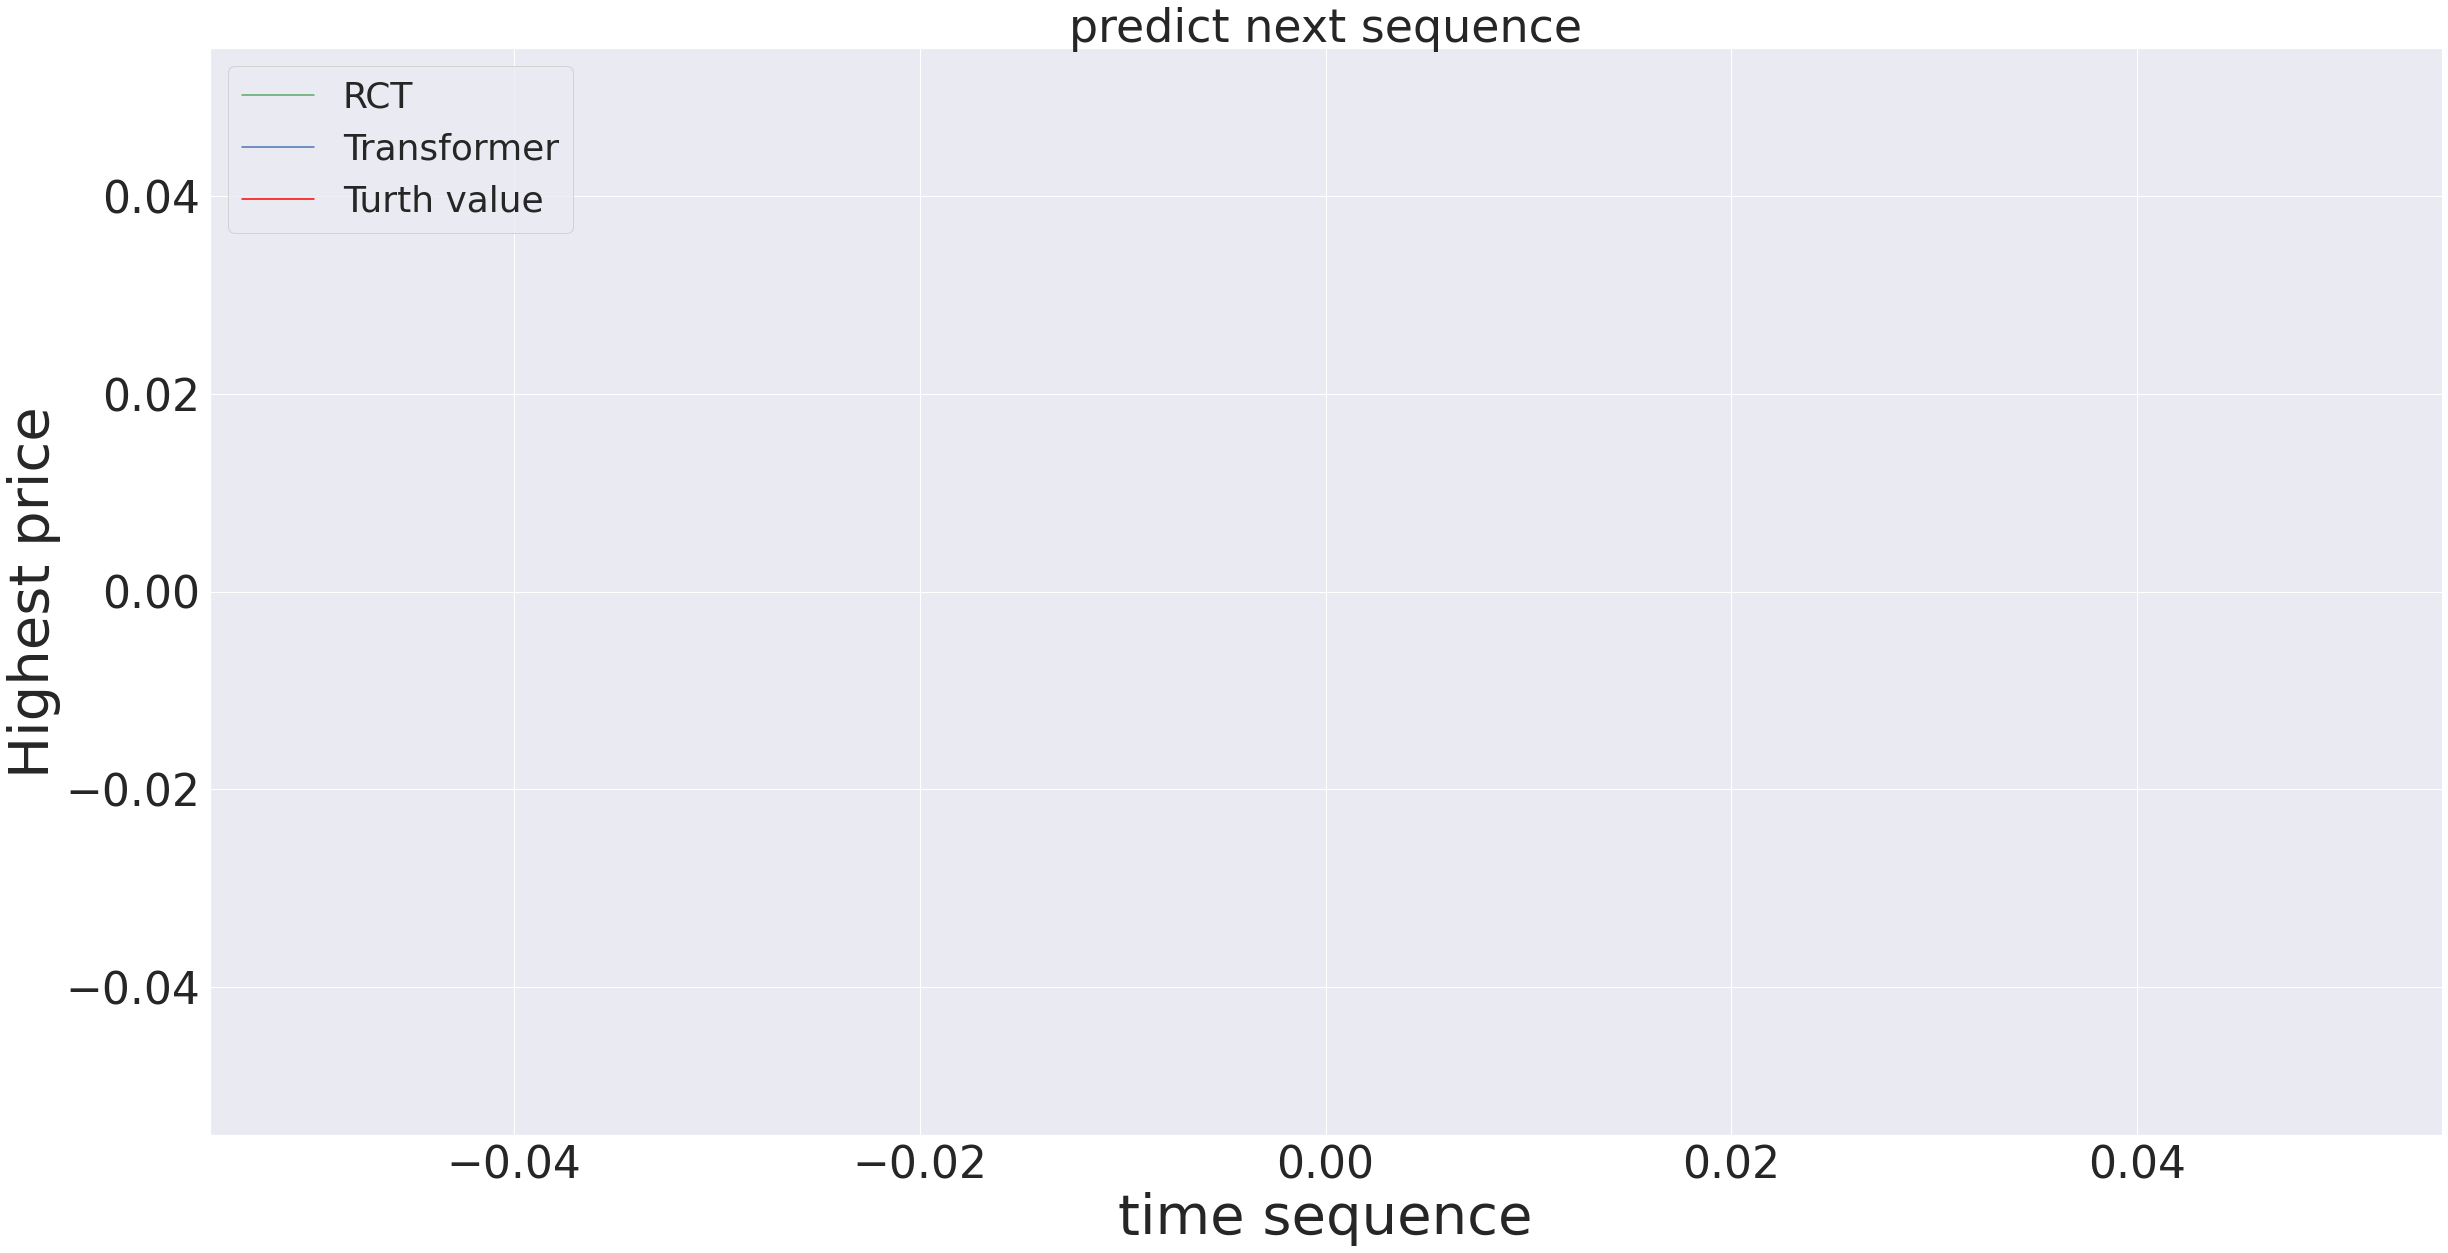

In [58]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 20]
i=2500
j=2600
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 4)
plt.figure()
plt.plot(xx[i:j],xpred[i:j], color='g', label='RCT', zorder=10)
plt.plot(xx[i:j],trans_x_predict[i:j], color='b', label='Transformer', zorder=10)
plt.plot(xx[i:j],y_train1[i:j], color='red', label='Turth value')

plt.scatter(xx[i:j],xpred[i:j], color='g', s=220, zorder=2)
plt.scatter(xx[i:j],trans_x_predict[i:j], color='b', s=220, zorder=2)
plt.scatter(xx[i:j],y_train1[i:j],  s=220, color='red', zorder=2)

plt.legend(loc="upper left", fontsize=36)
plt.title('predict next sequence', fontsize=46)
plt.xlabel('time sequence', fontsize=56)
plt.ylabel('Highest price', fontsize=56)
plt.show()

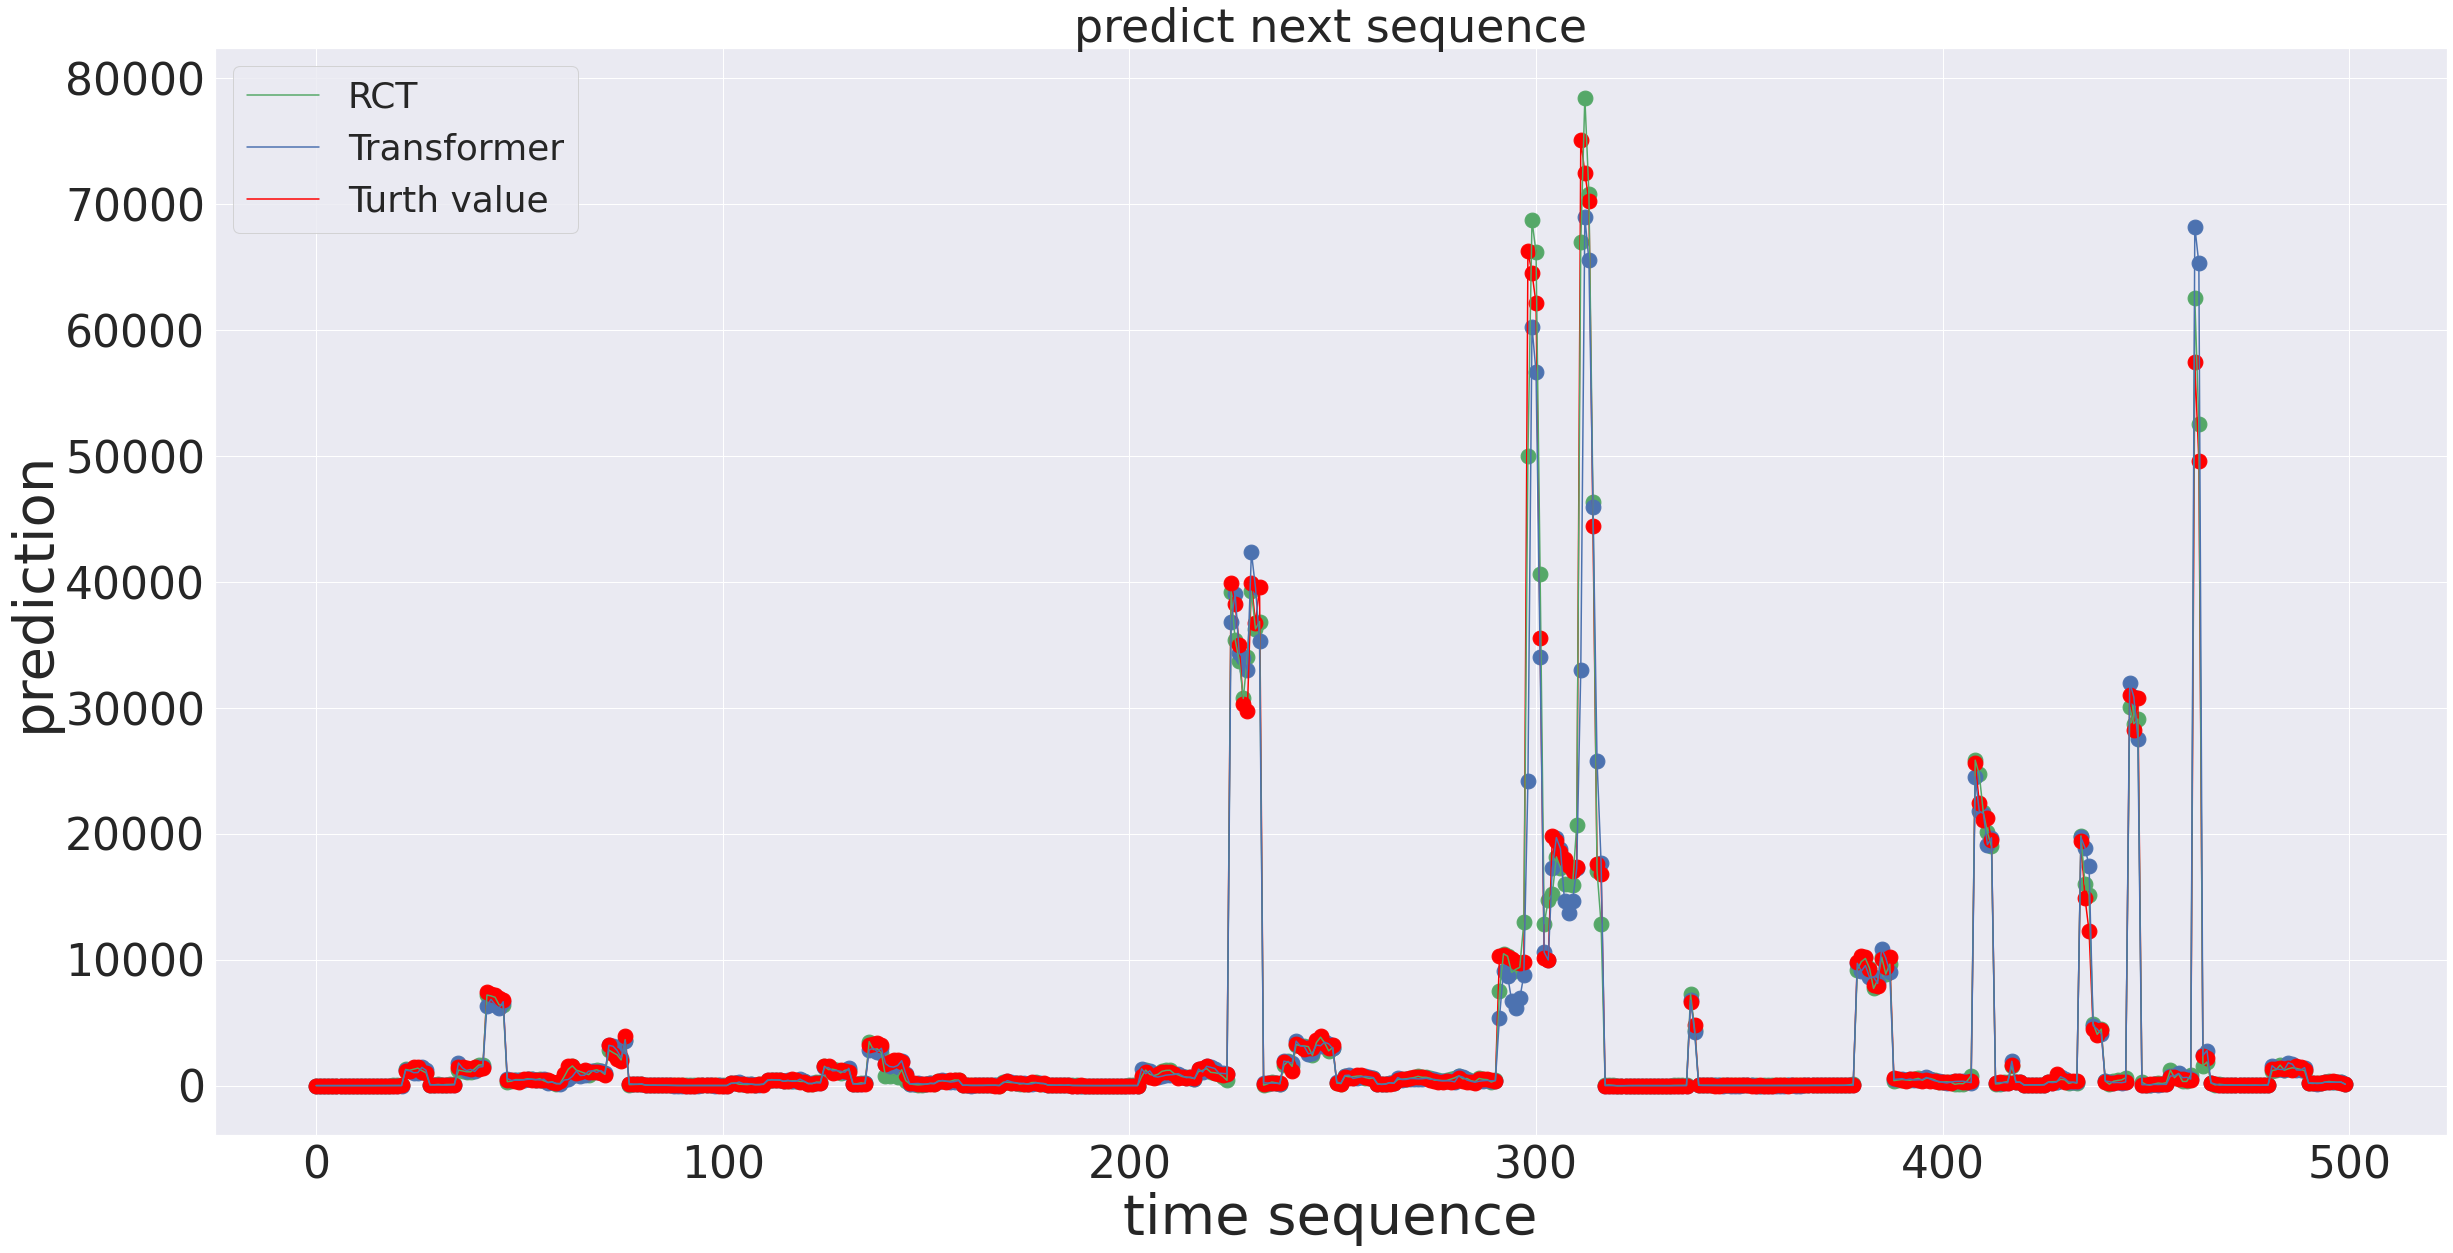

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 20]
i=0
j=500
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 4)
plt.figure()
plt.plot(xx[i:j],xpred[i:j], color='g', label='RCT', zorder=10)
plt.plot(xx[i:j],trans_x_predict[i:j], color='b', label='Transformer', zorder=10)
plt.plot(xx[i:j],y_train1[i:j], color='red', label='Turth value')

plt.scatter(xx[i:j],xpred[i:j], color='g', s=220, zorder=2)
plt.scatter(xx[i:j],trans_x_predict[i:j], color='b', s=220, zorder=2)
plt.scatter(xx[i:j],y_train1[i:j],  s=220, color='red', zorder=2)

plt.legend(loc="upper left", fontsize=36)
plt.title('predict next sequence', fontsize=46)
plt.xlabel('time sequence', fontsize=56)
plt.ylabel('prediction', fontsize=56)
plt.show()